-----------------------------------


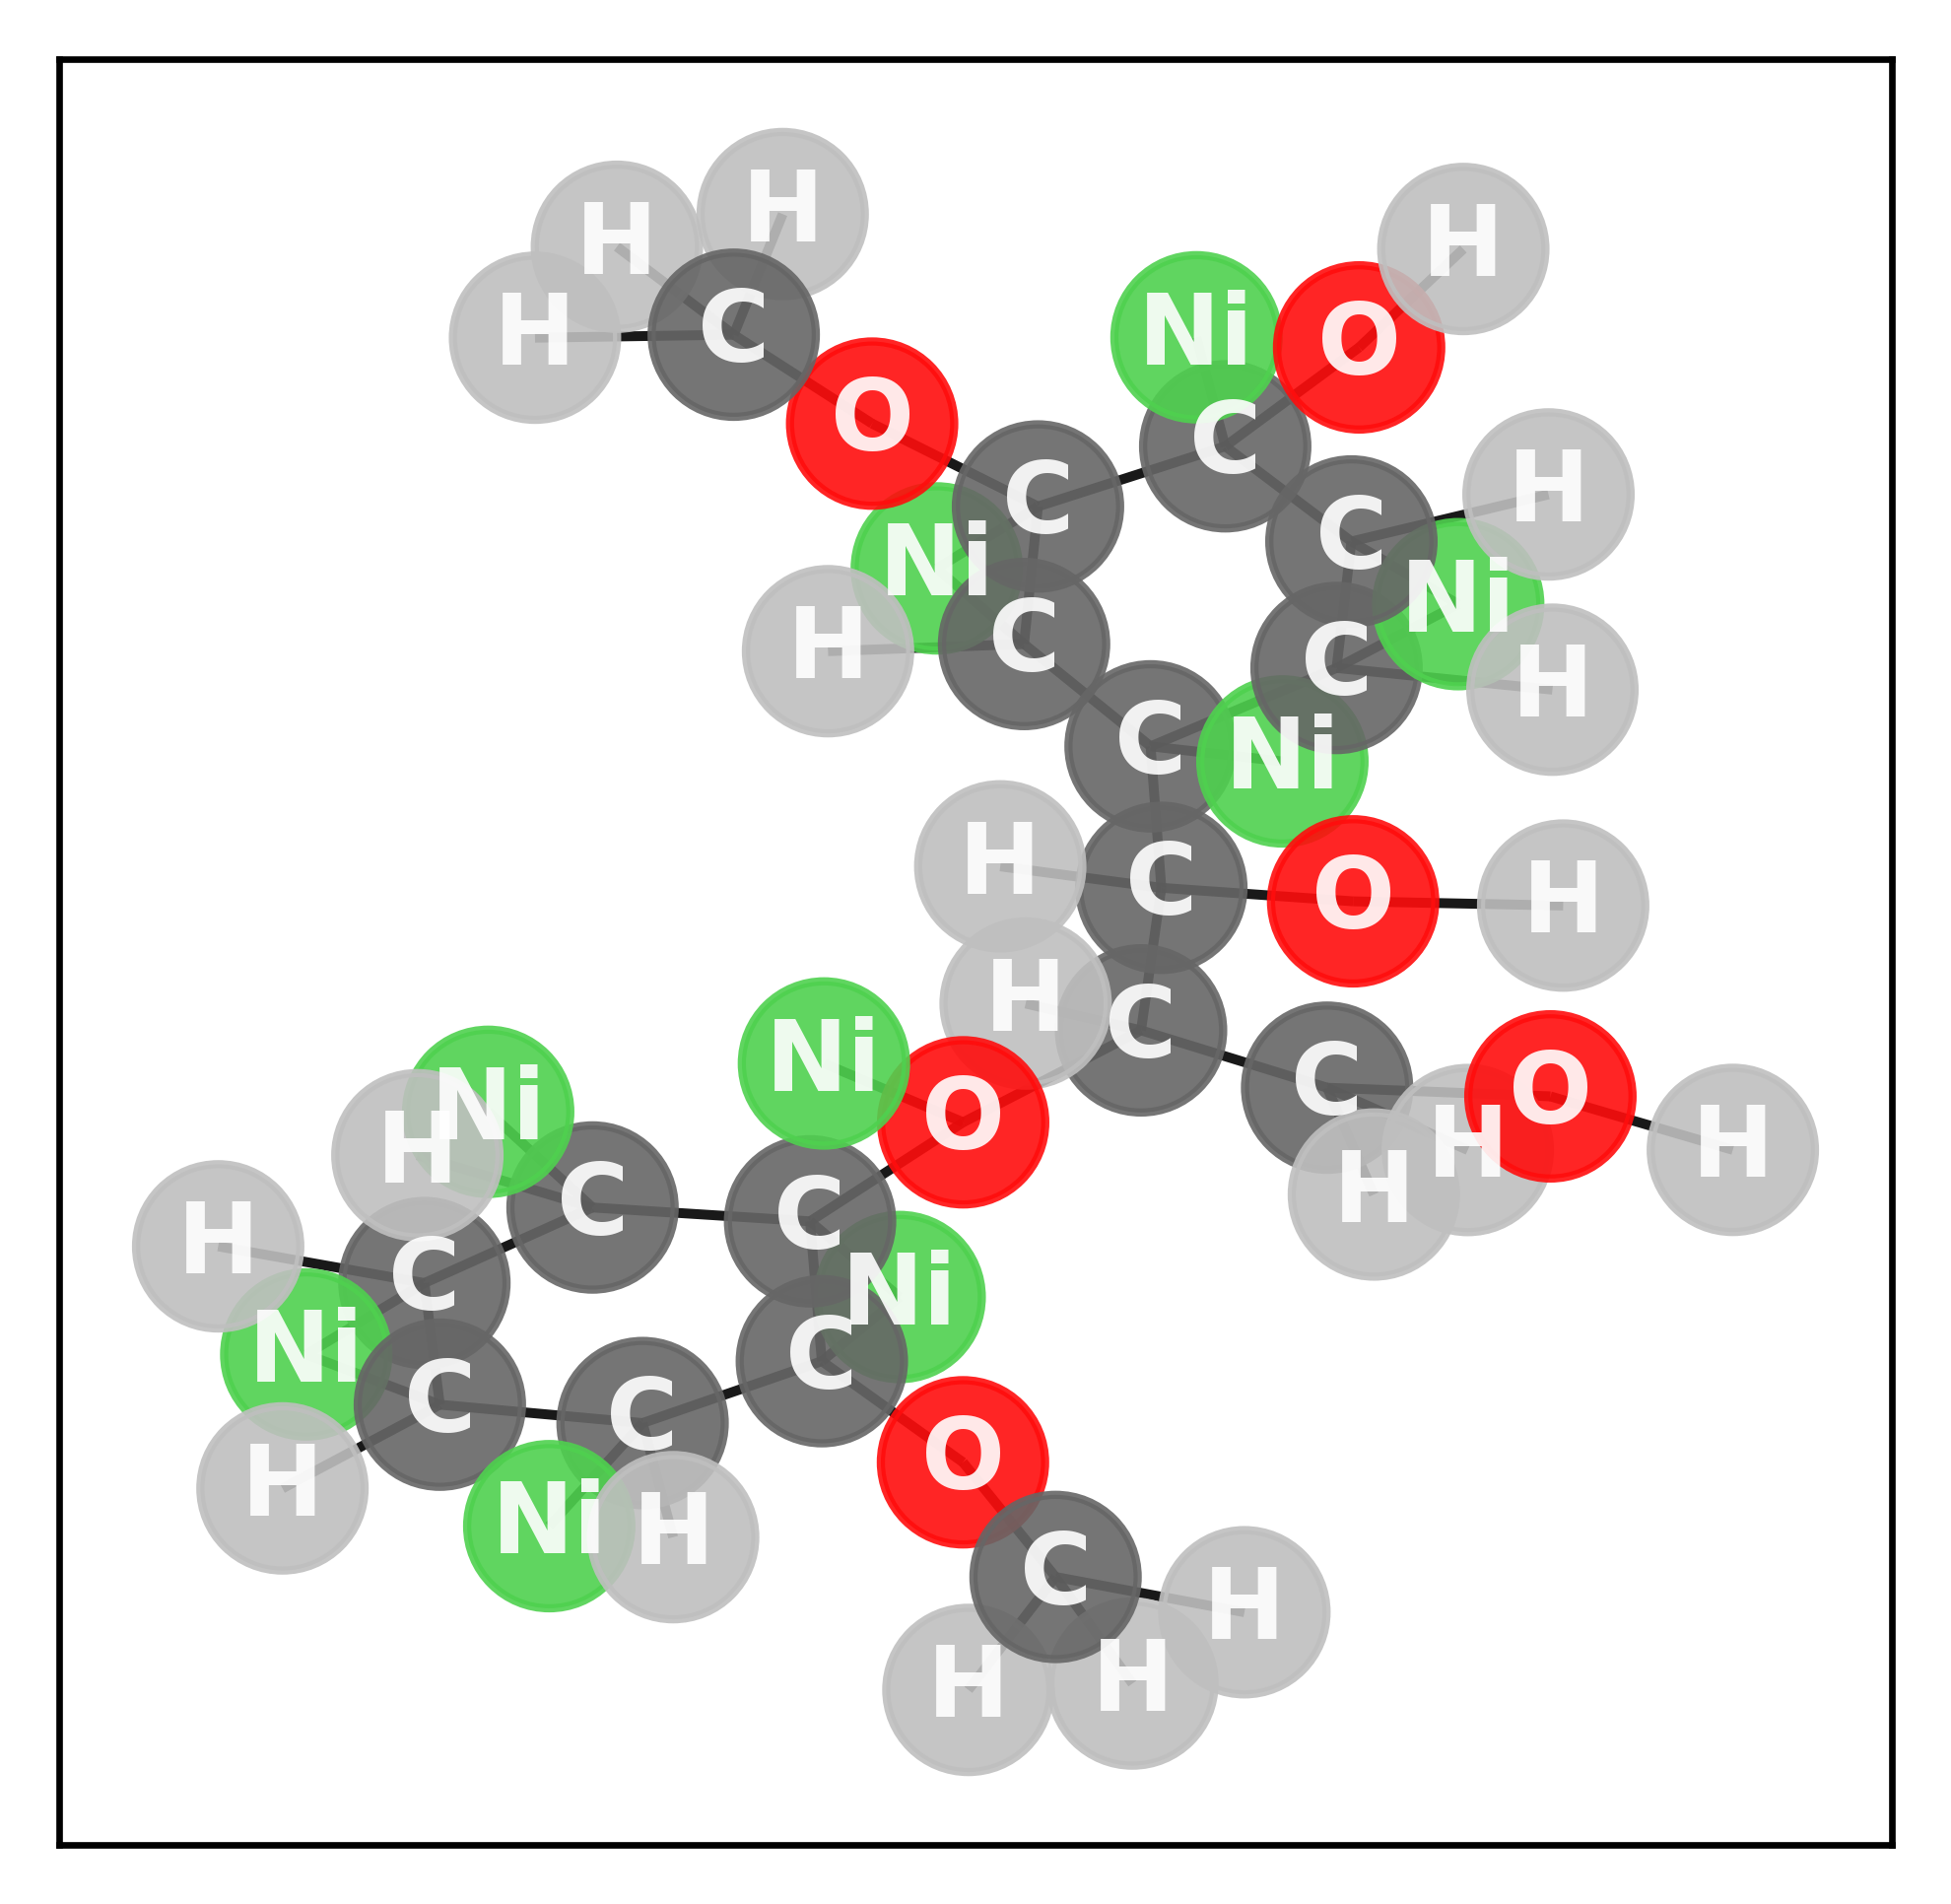

System: ni-mol1
GNN energy = -269.18 eV 
VASP energy = -269.48505176 eV
Prediction error = -0.30 eV
-----------------------------------


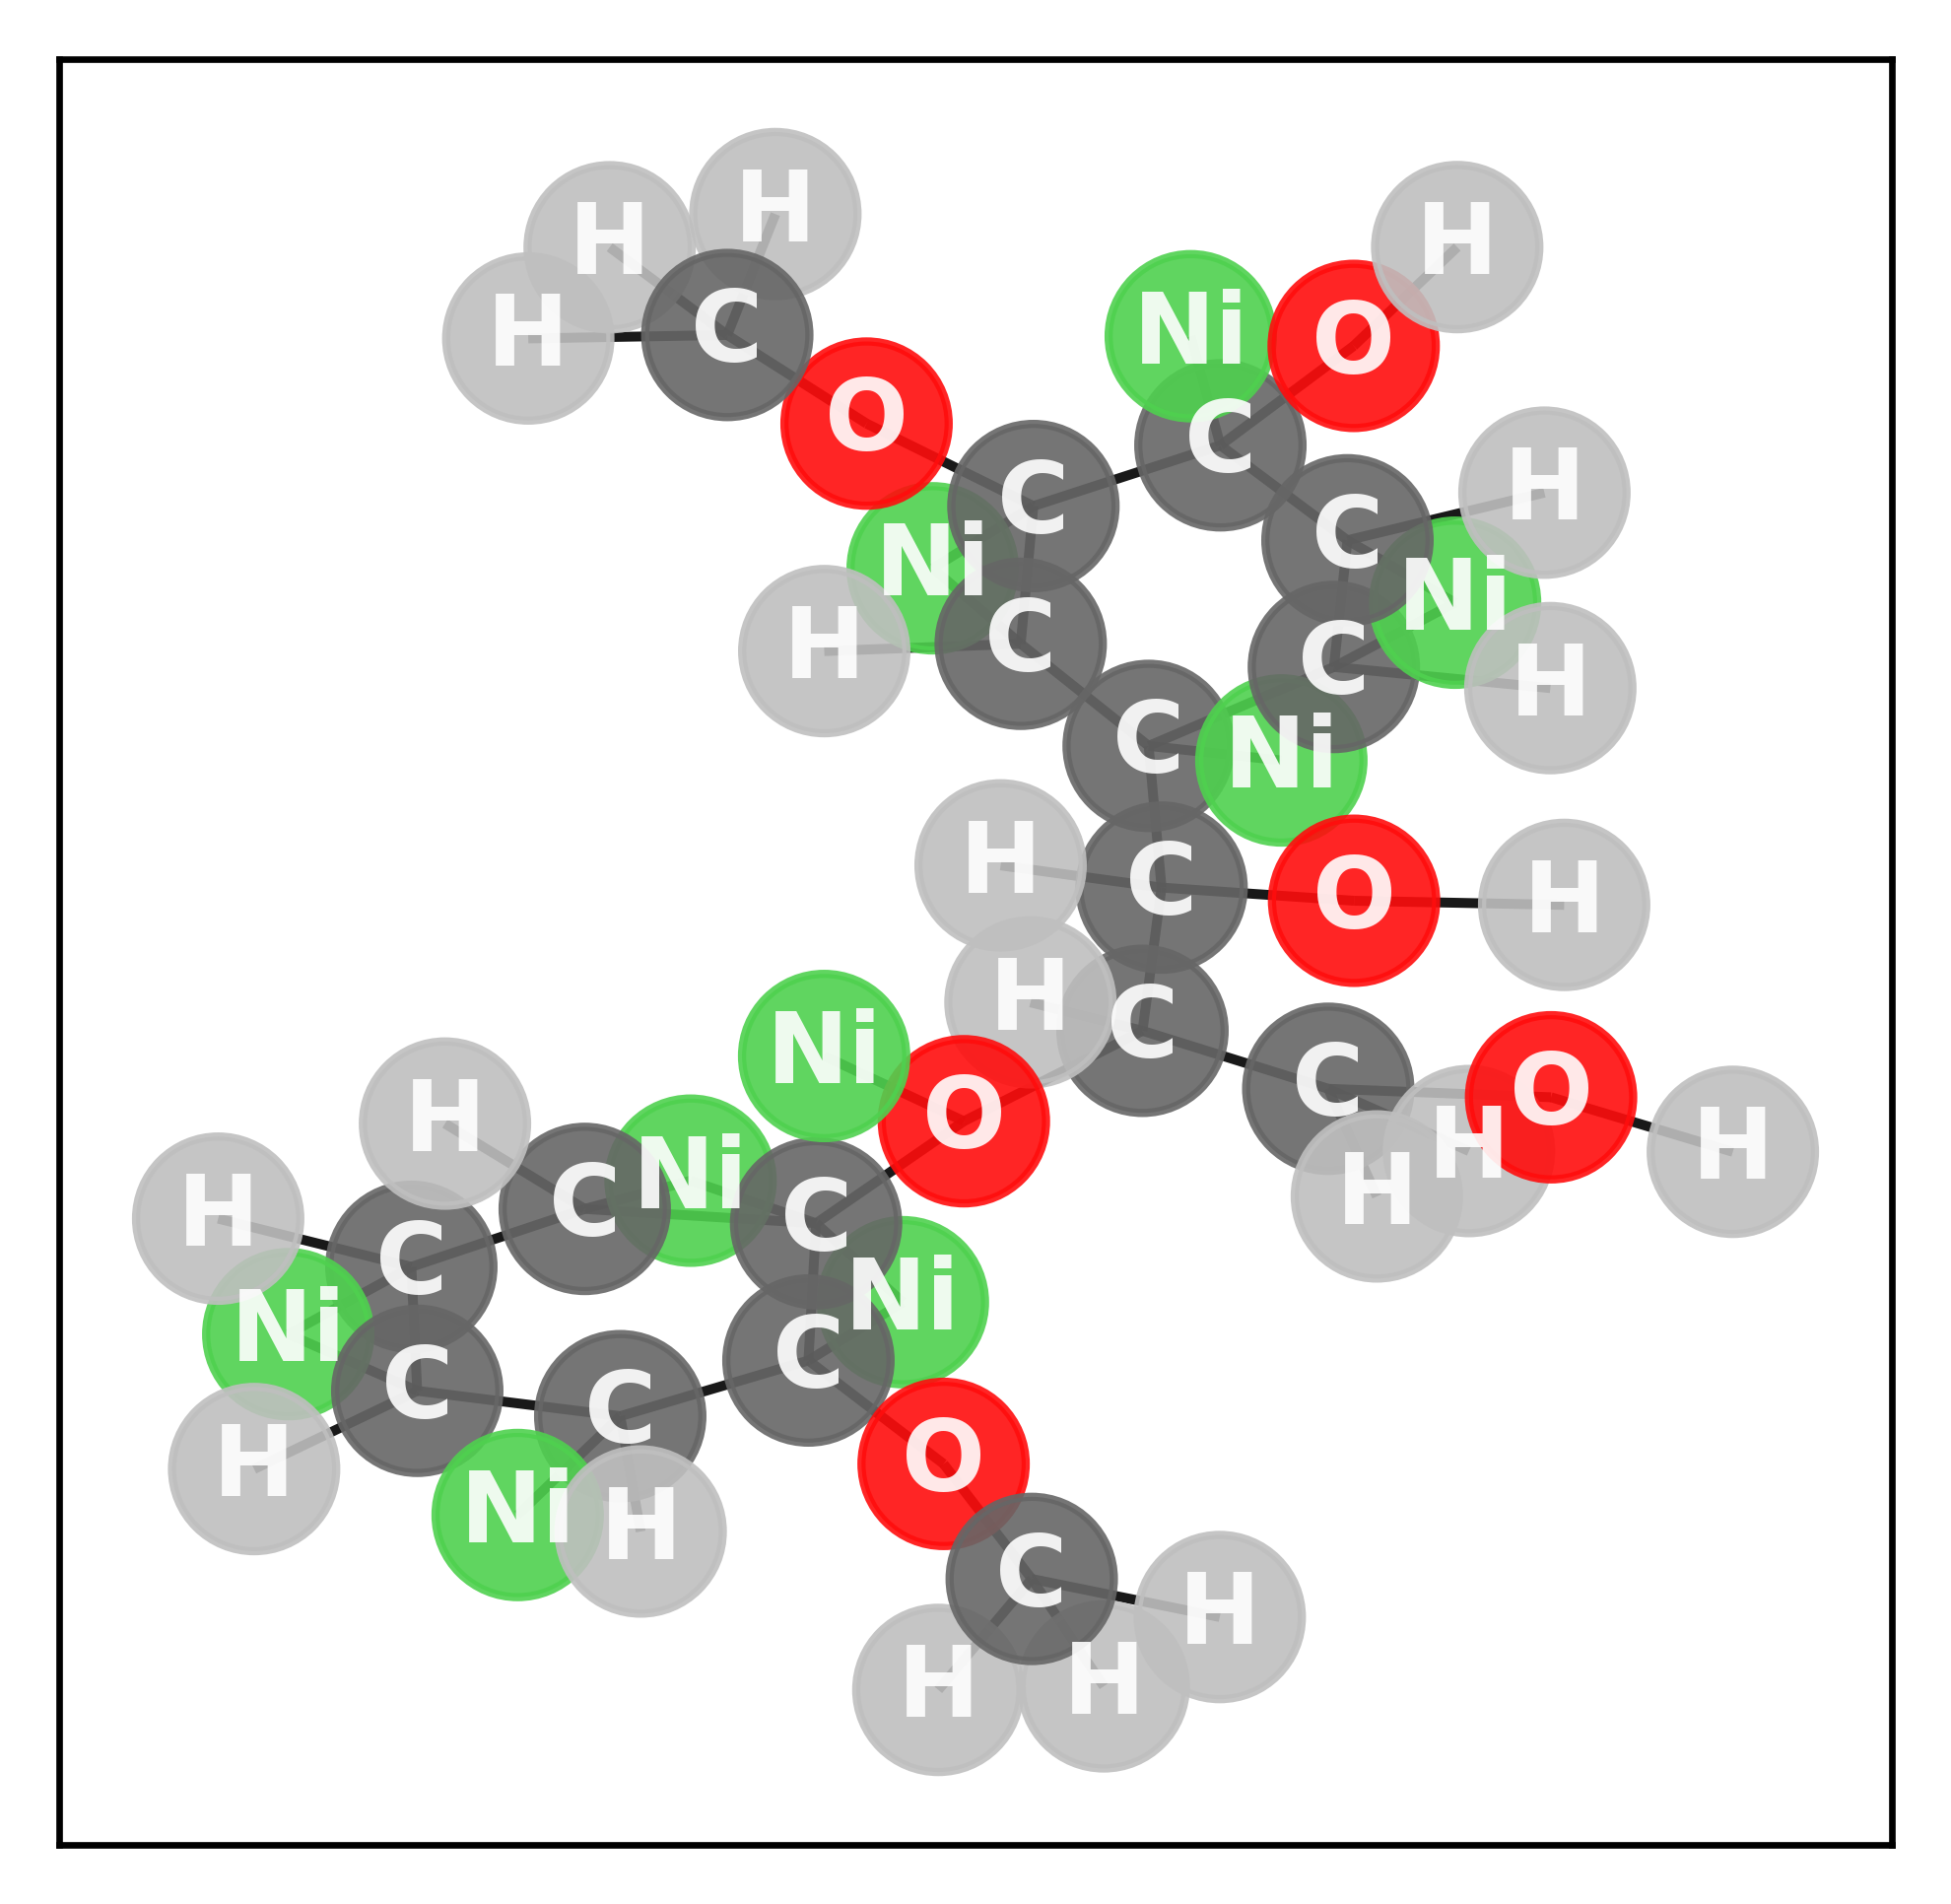

System: ni-mol2
GNN energy = -269.35 eV 
VASP energy = -268.97141166 eV
Prediction error = 0.37 eV
-----------------------------------


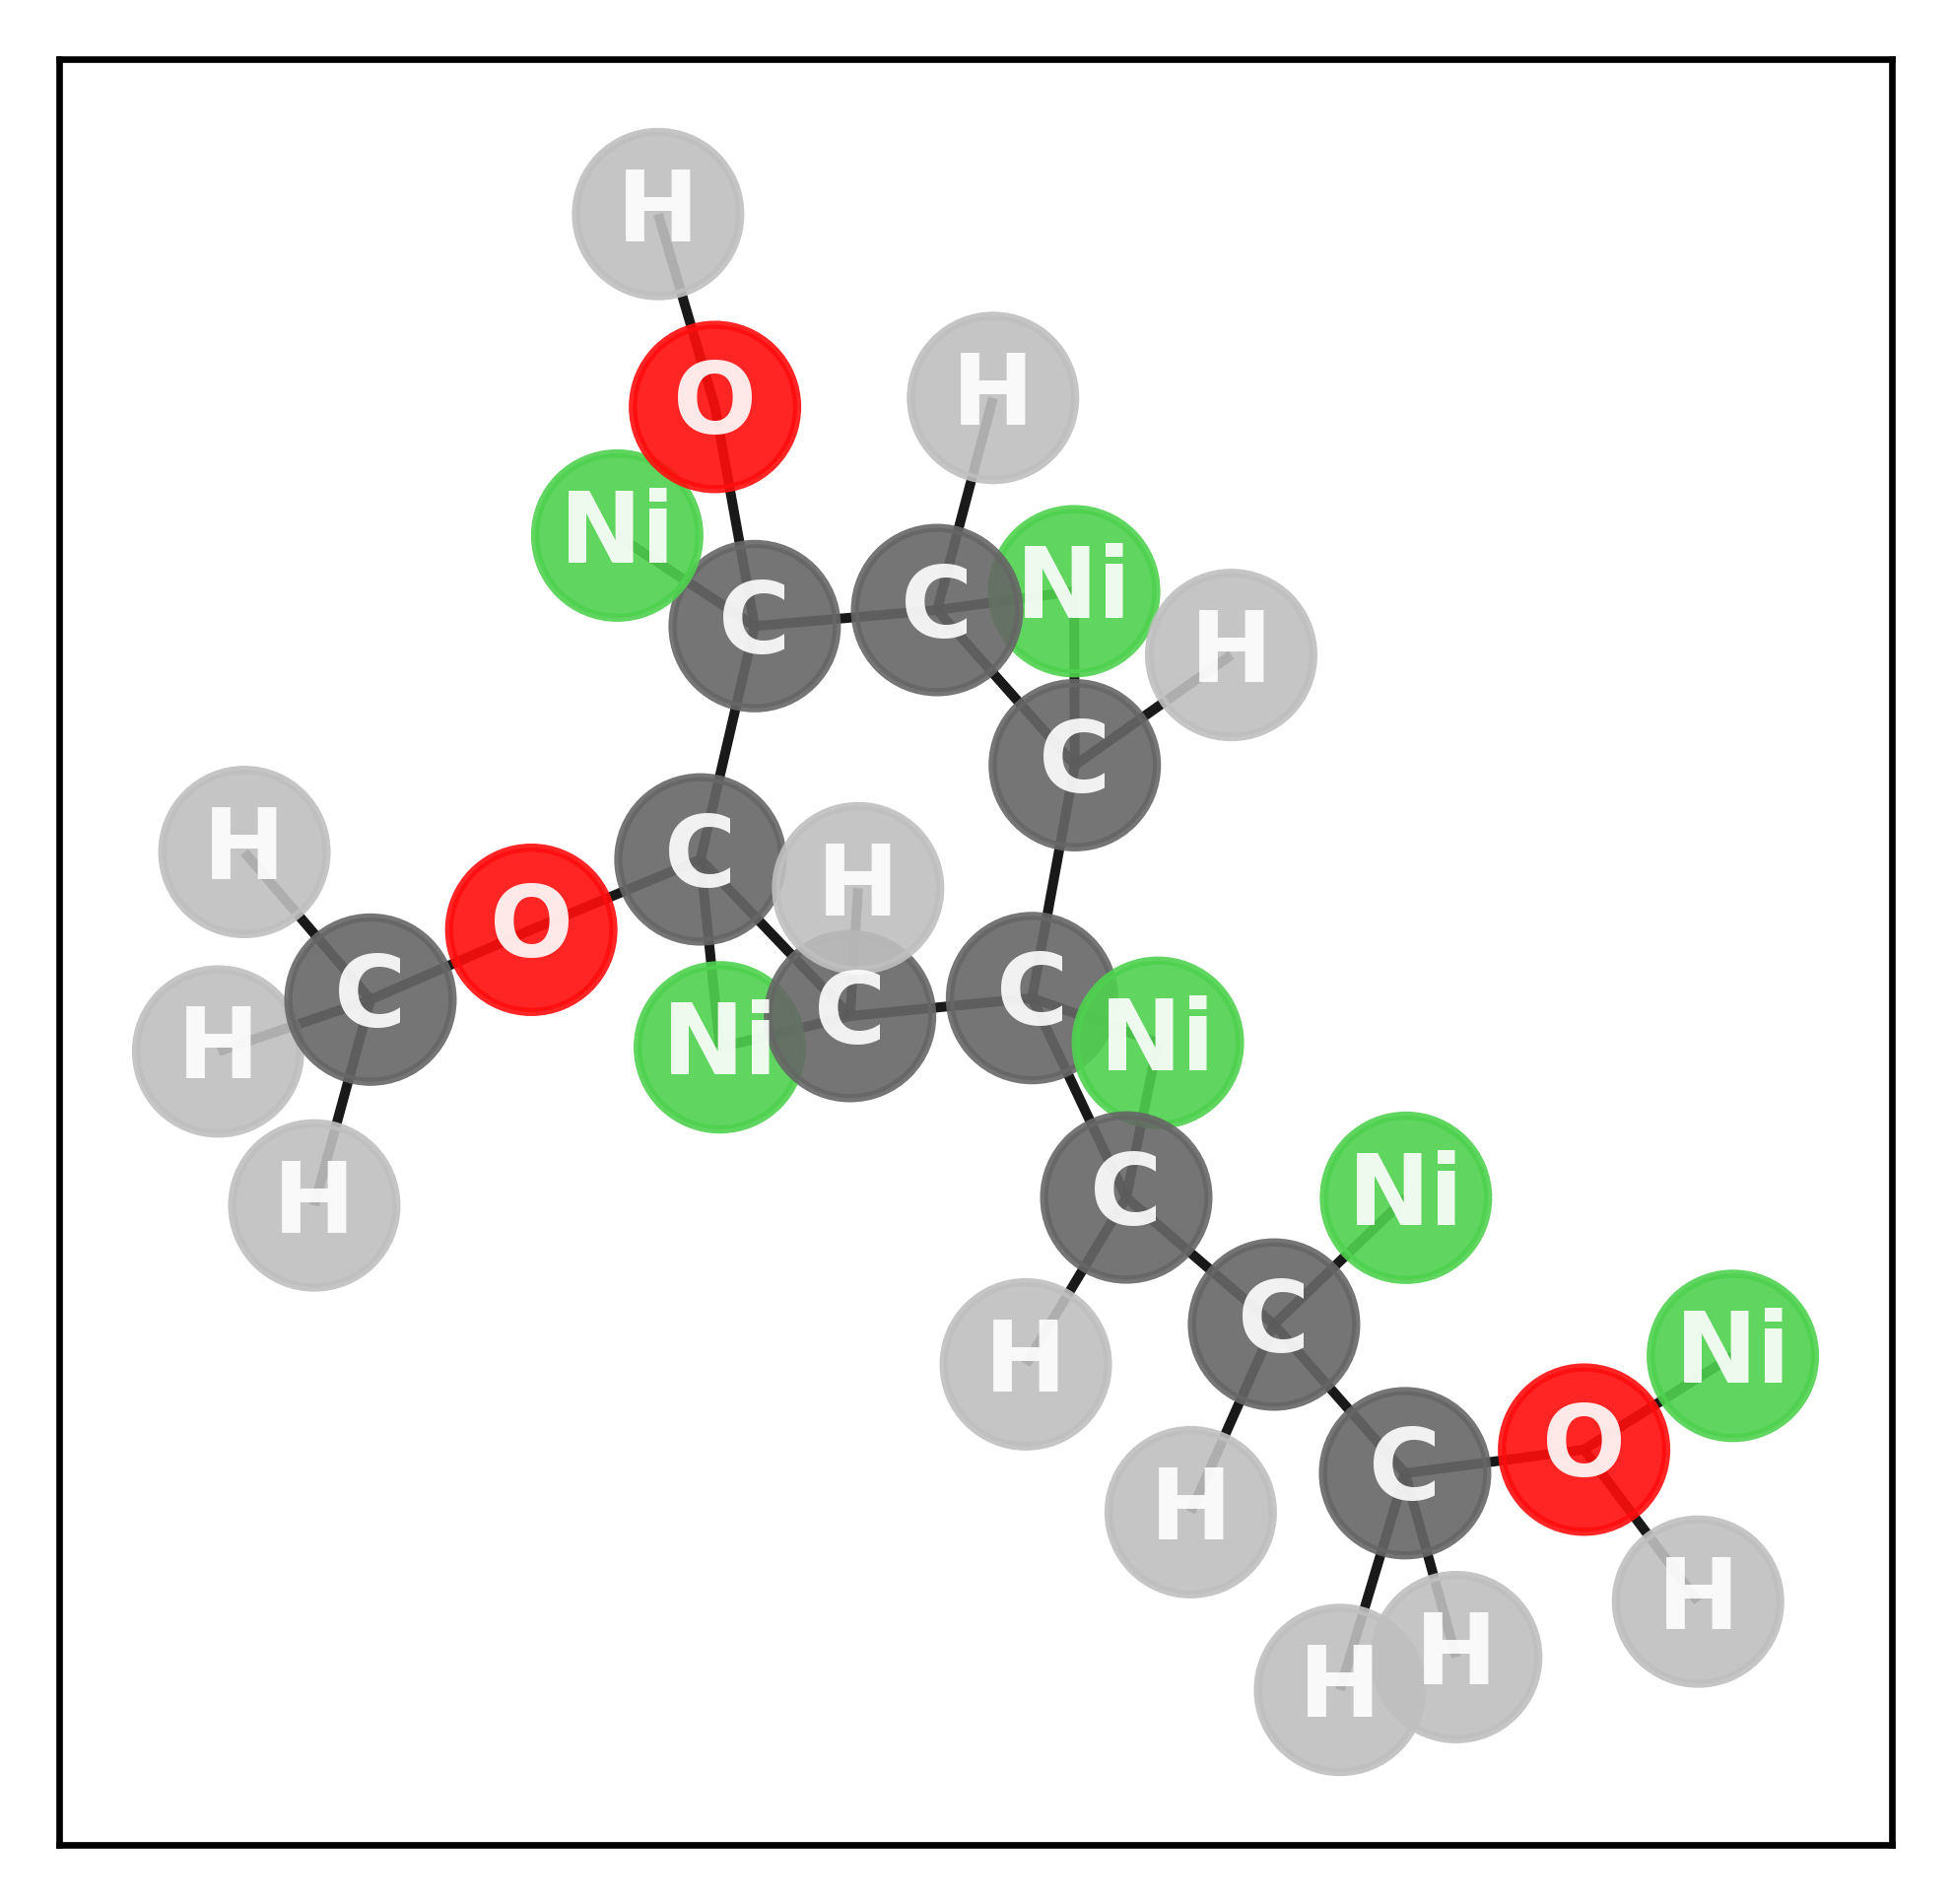

System: ni-mol3
GNN energy = -155.83 eV 
VASP energy = -156.38838357000003 eV
Prediction error = -0.56 eV
-----------------------------------


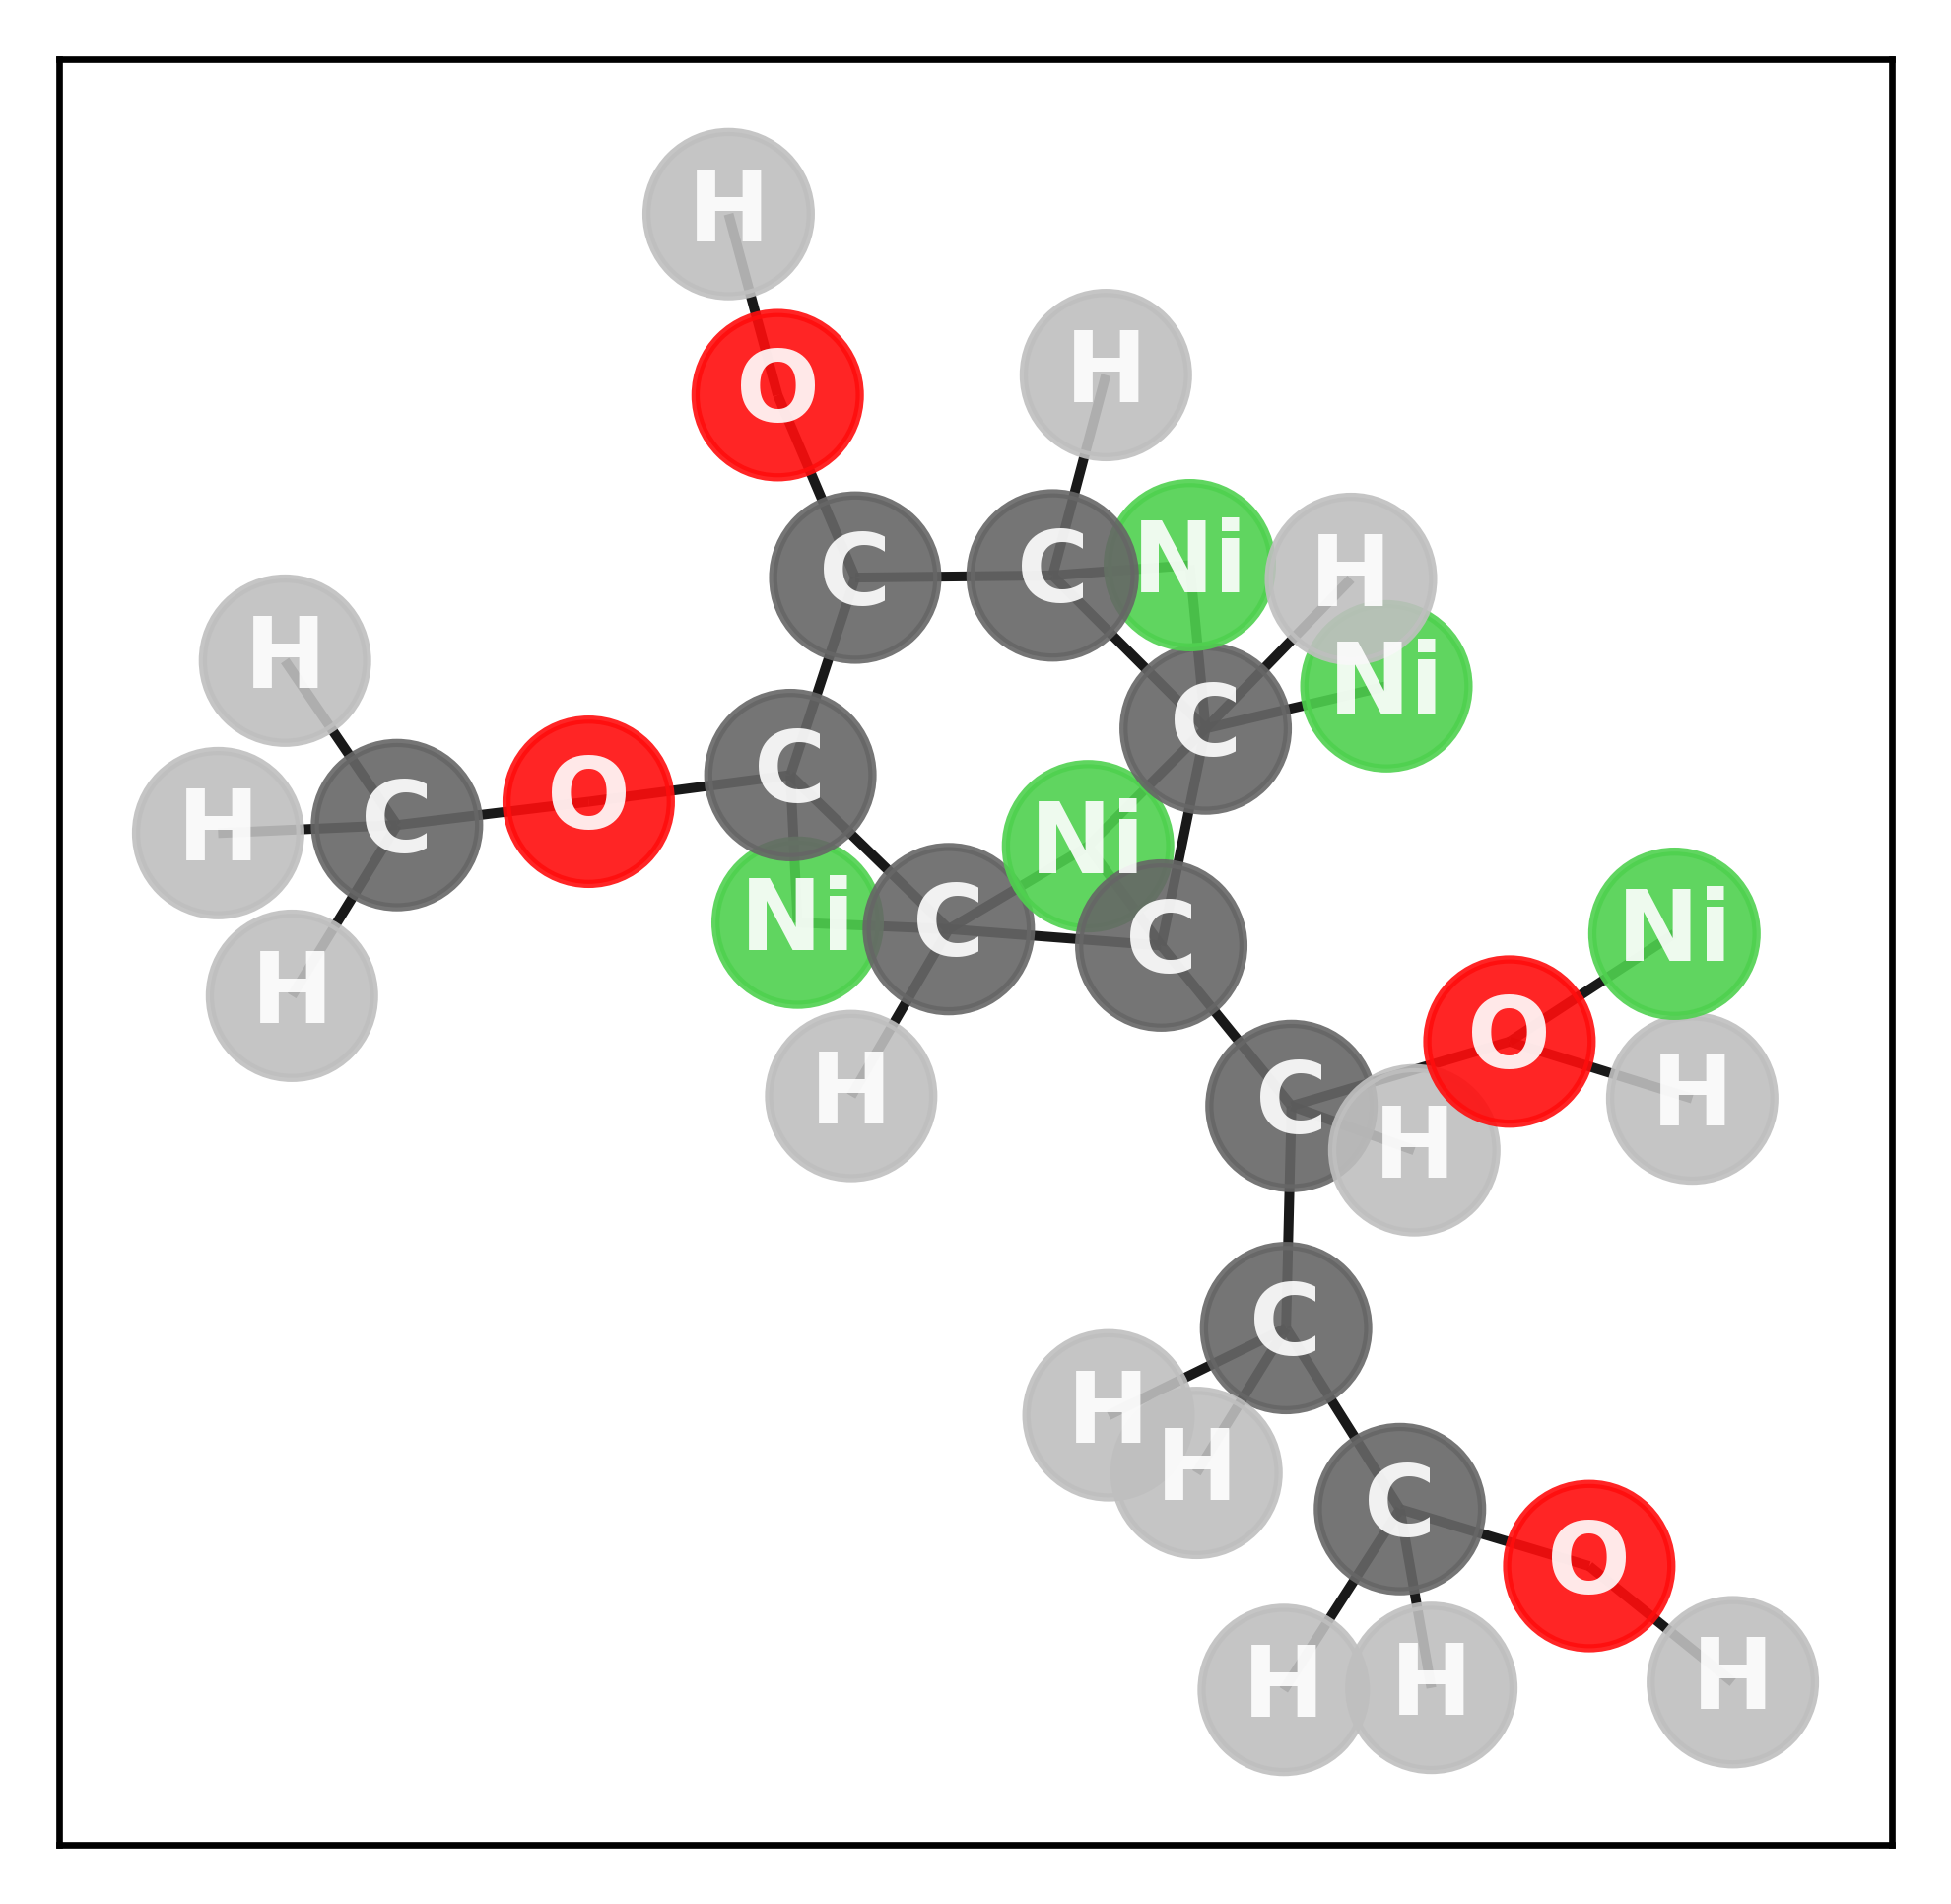

System: ni-mol4
GNN energy = -169.65 eV 
VASP energy = -170.59217589999997 eV
Prediction error = -0.94 eV
-----------------------------------


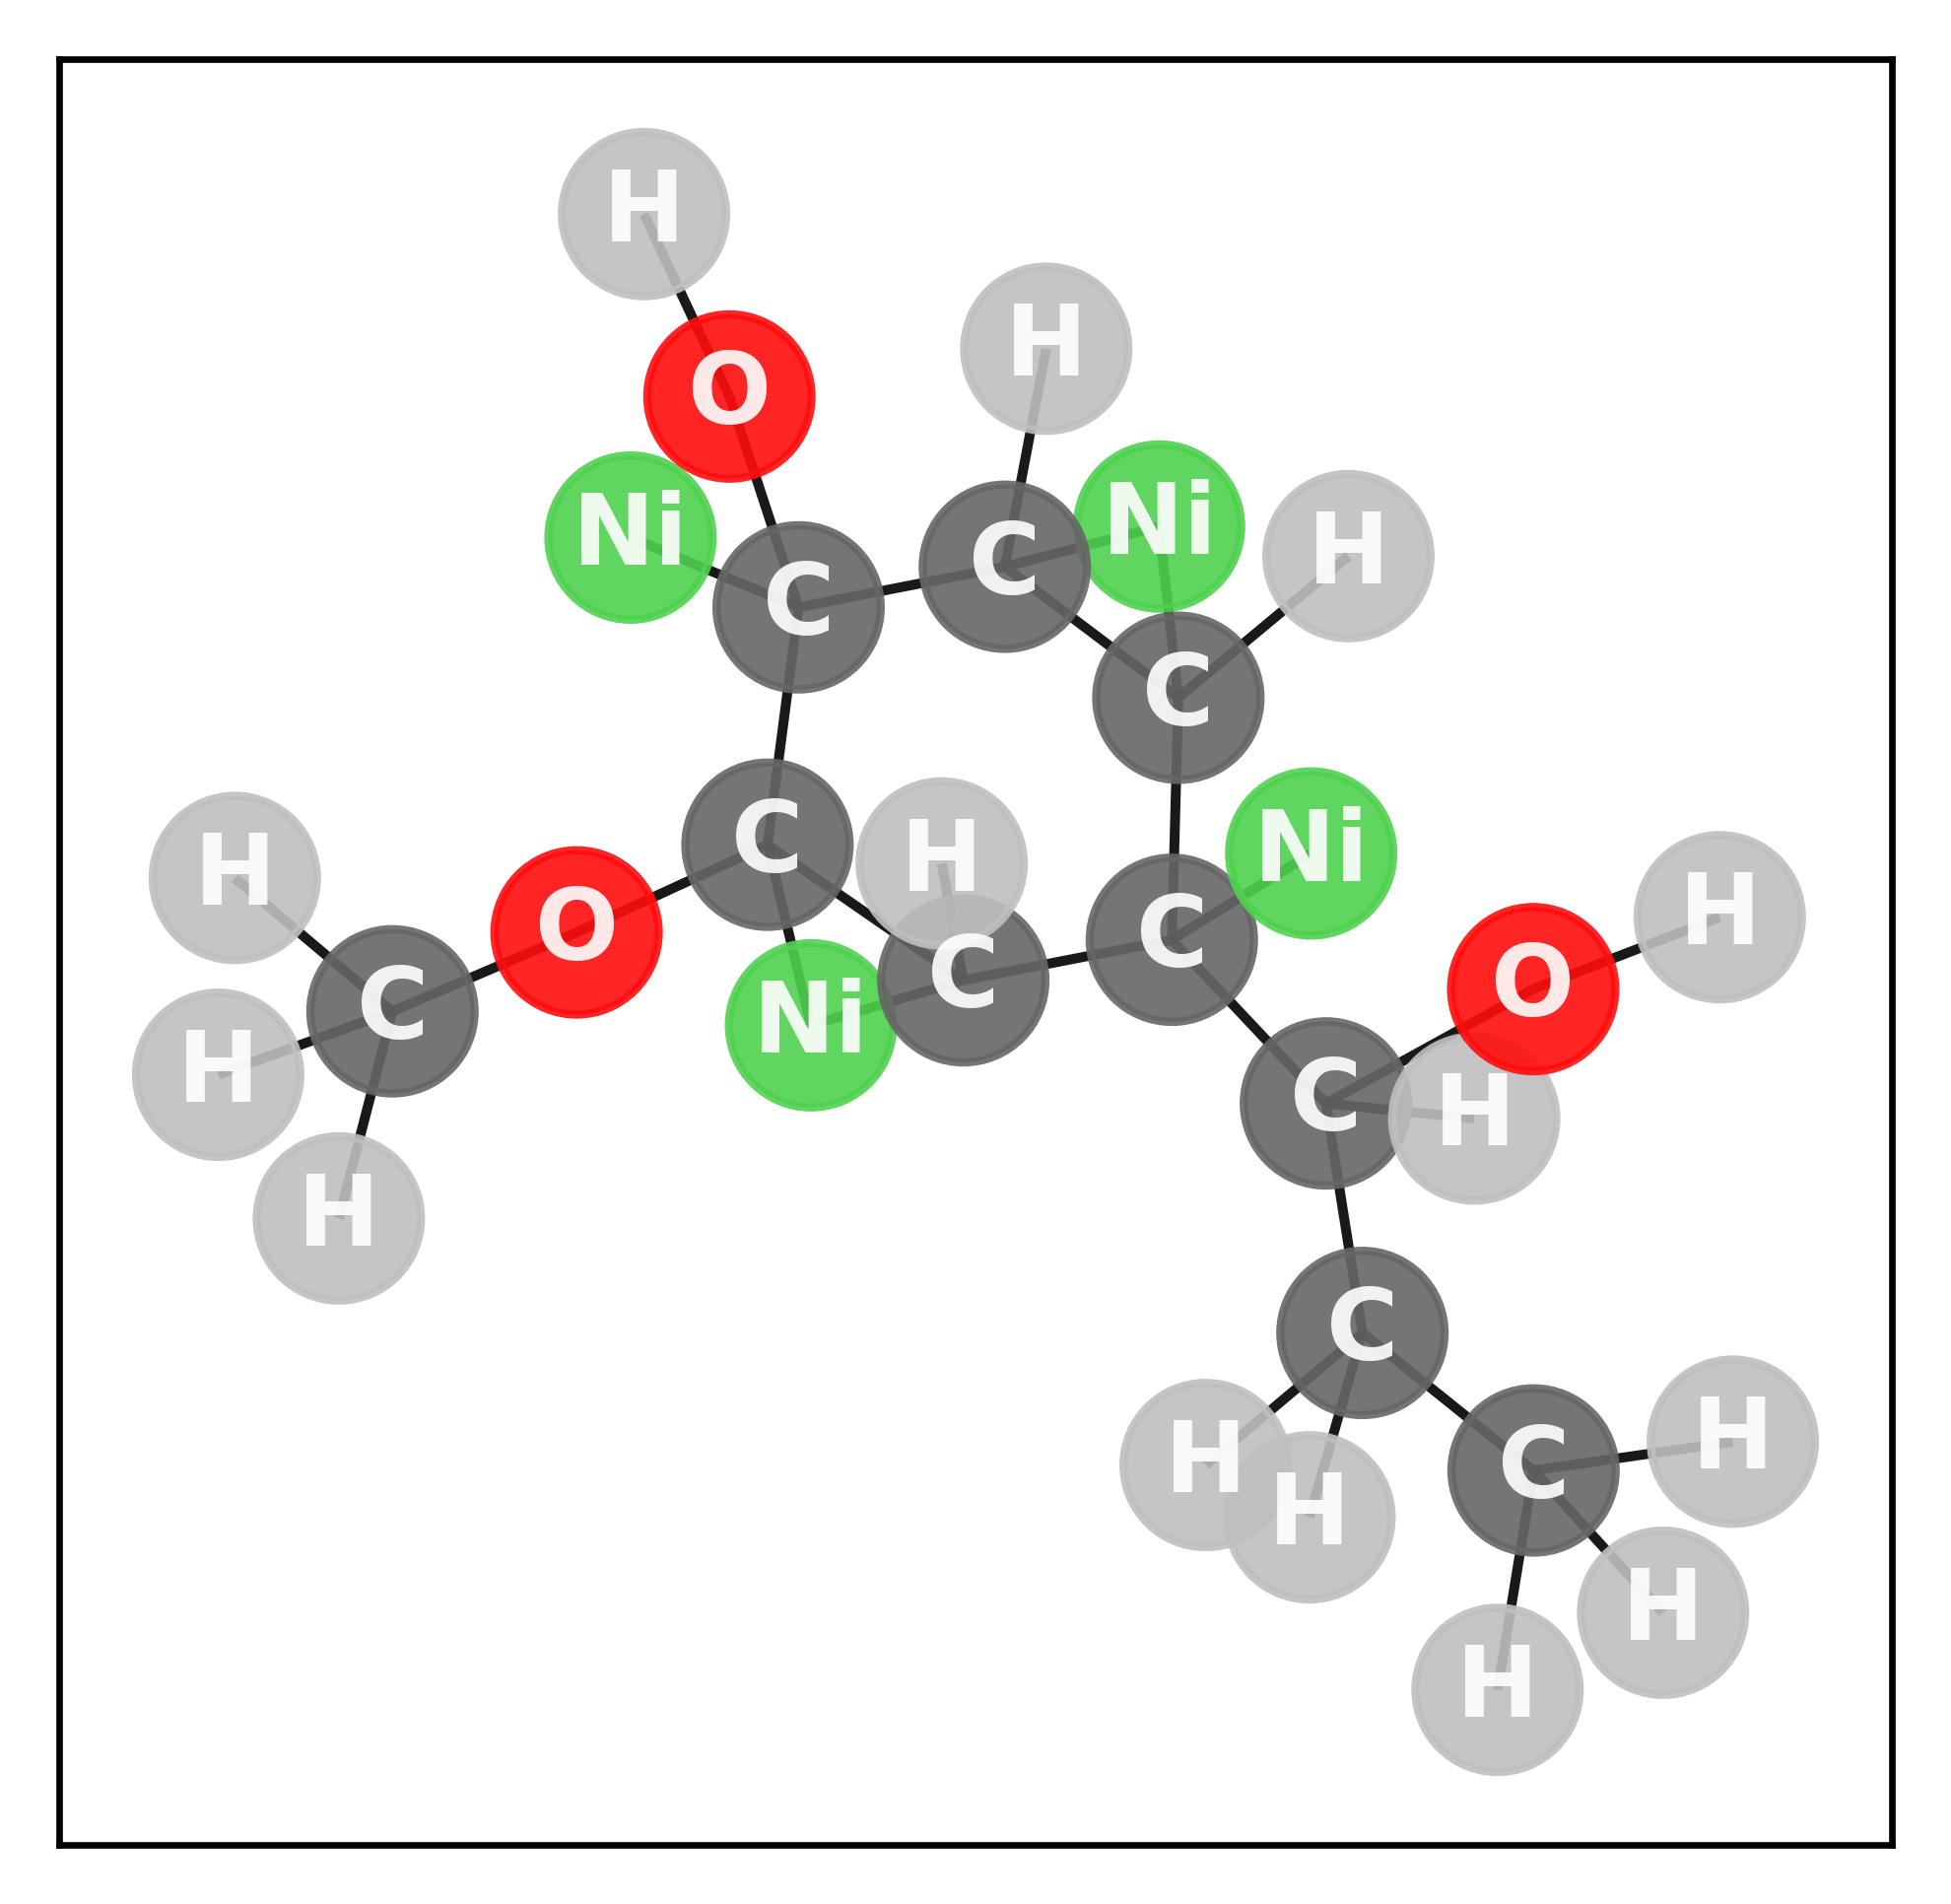

System: ni-mol5
GNN energy = -163.15 eV 
VASP energy = -163.79779004000005 eV
Prediction error = -0.65 eV
-----------------------------------


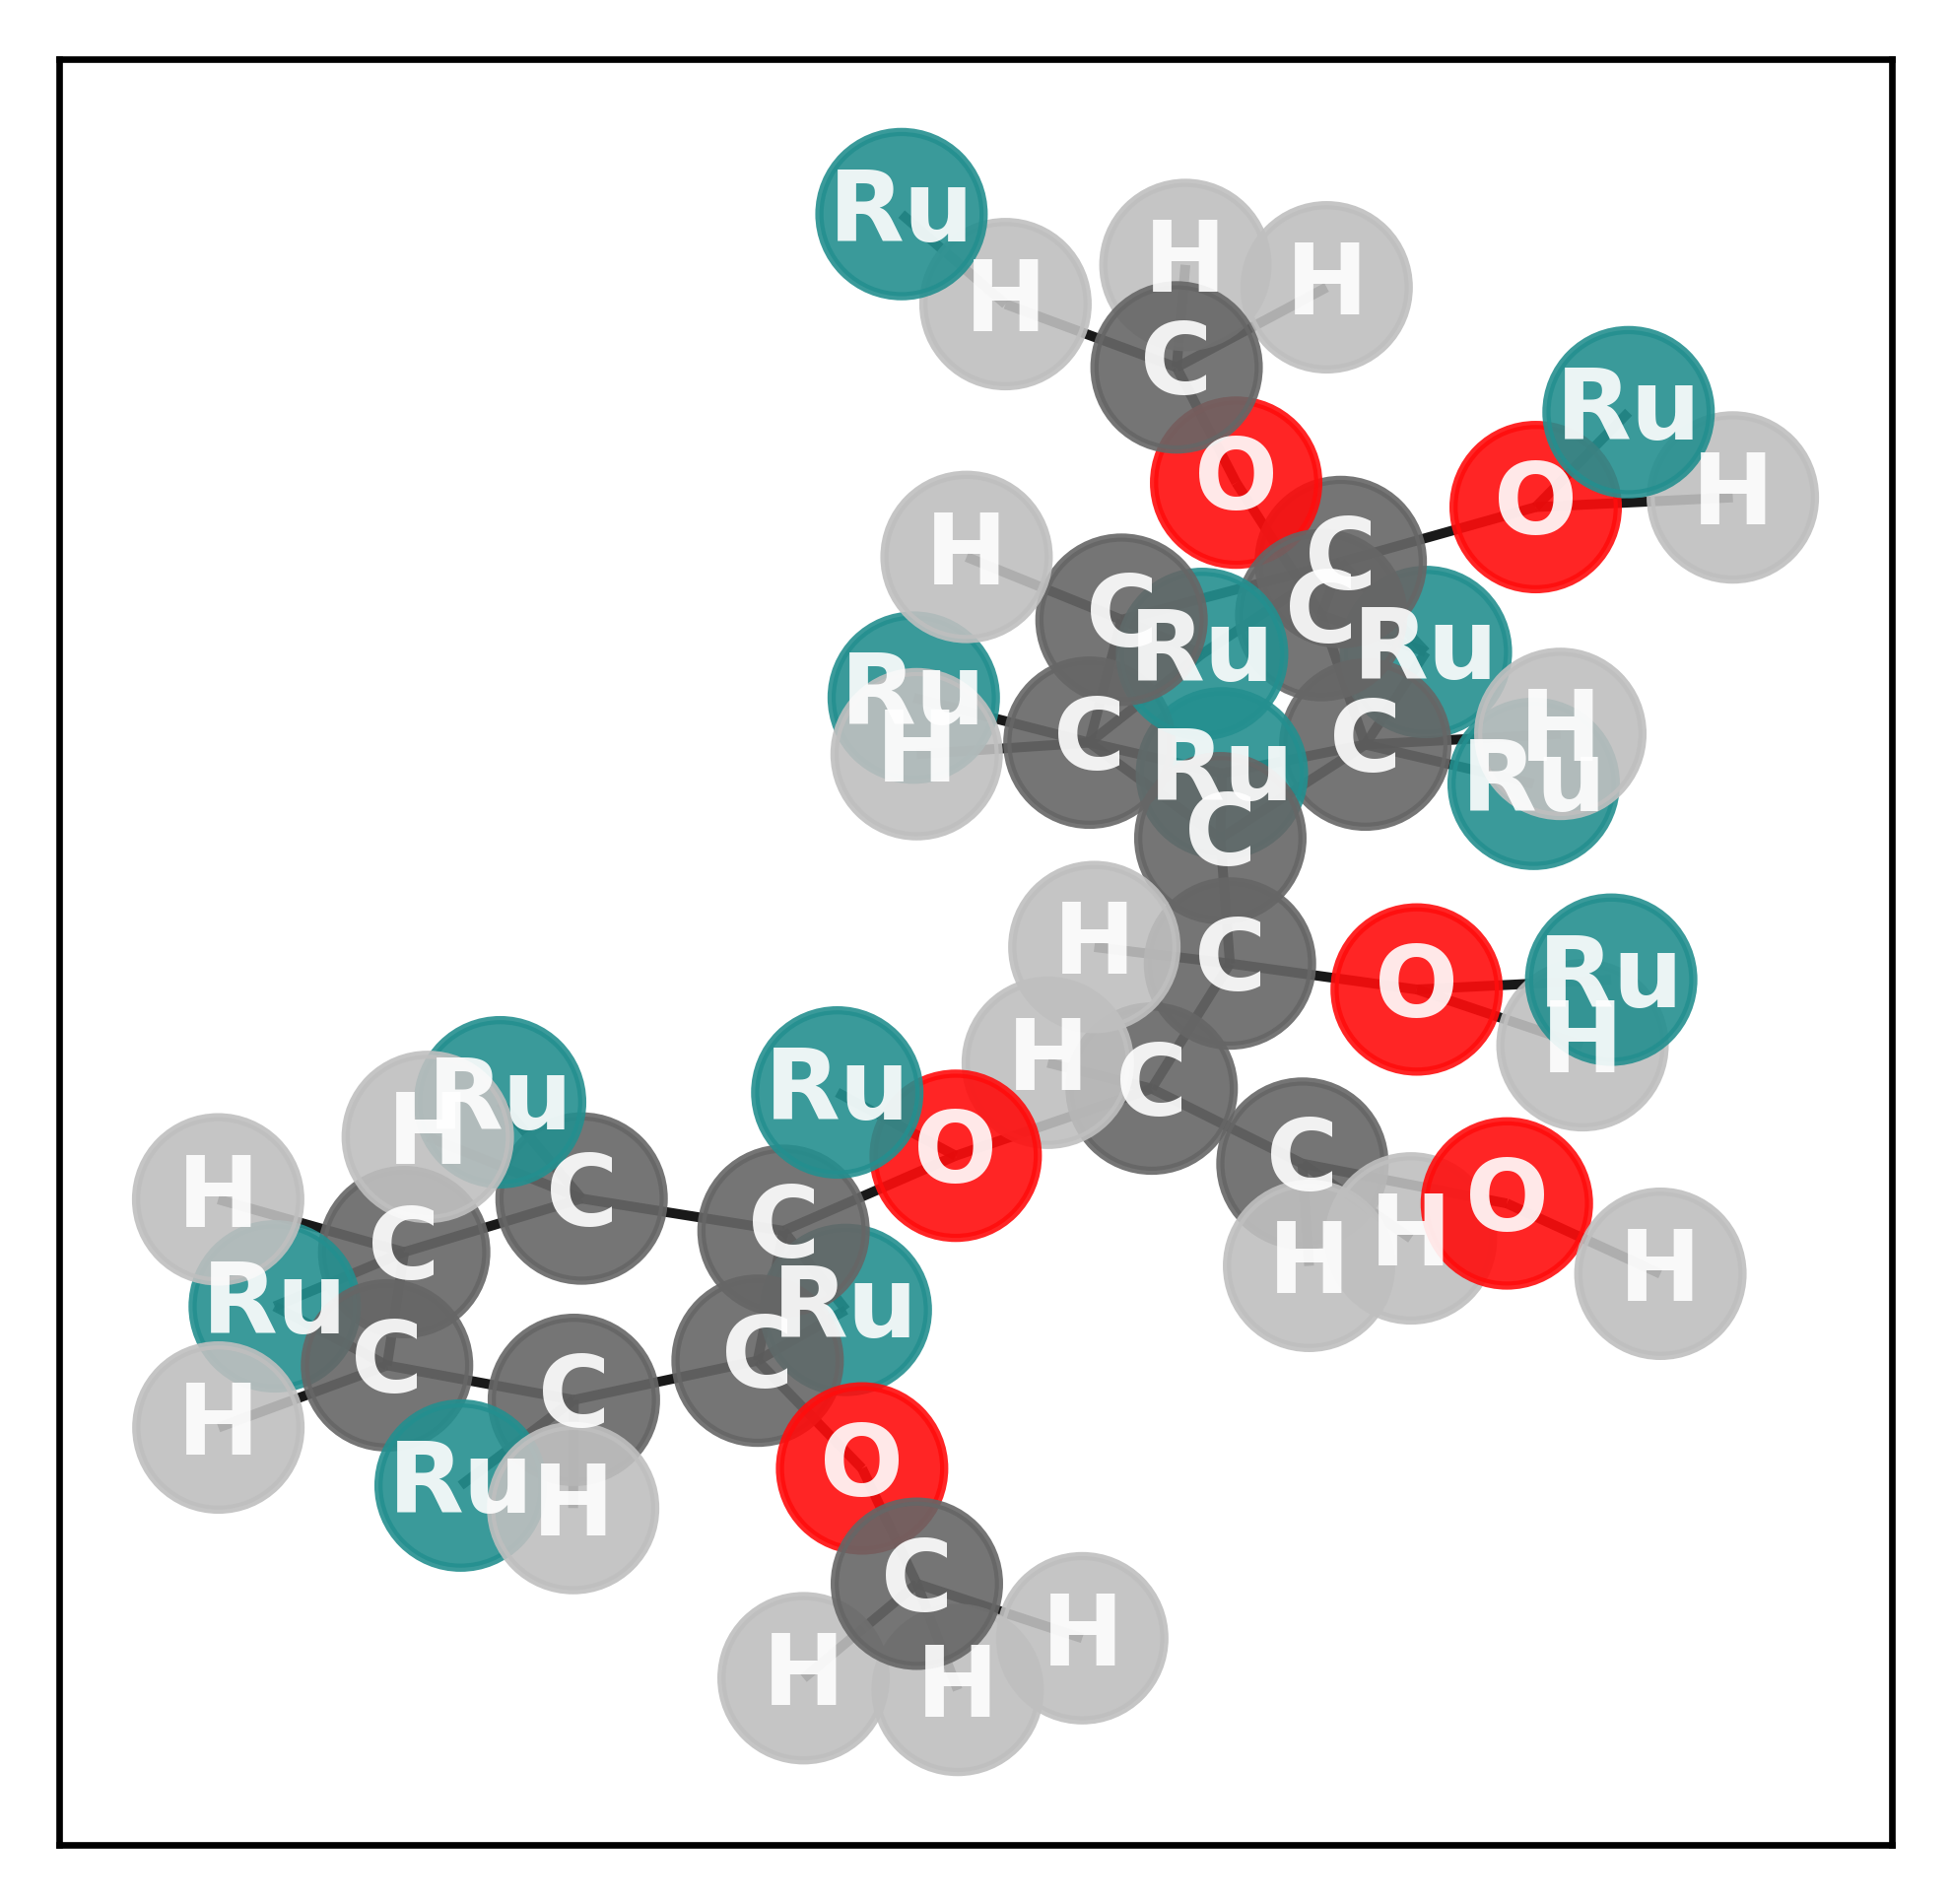

System: ru-mol1
GNN energy = -270.48 eV 
VASP energy = -270.26880955 eV
Prediction error = 0.21 eV
-----------------------------------


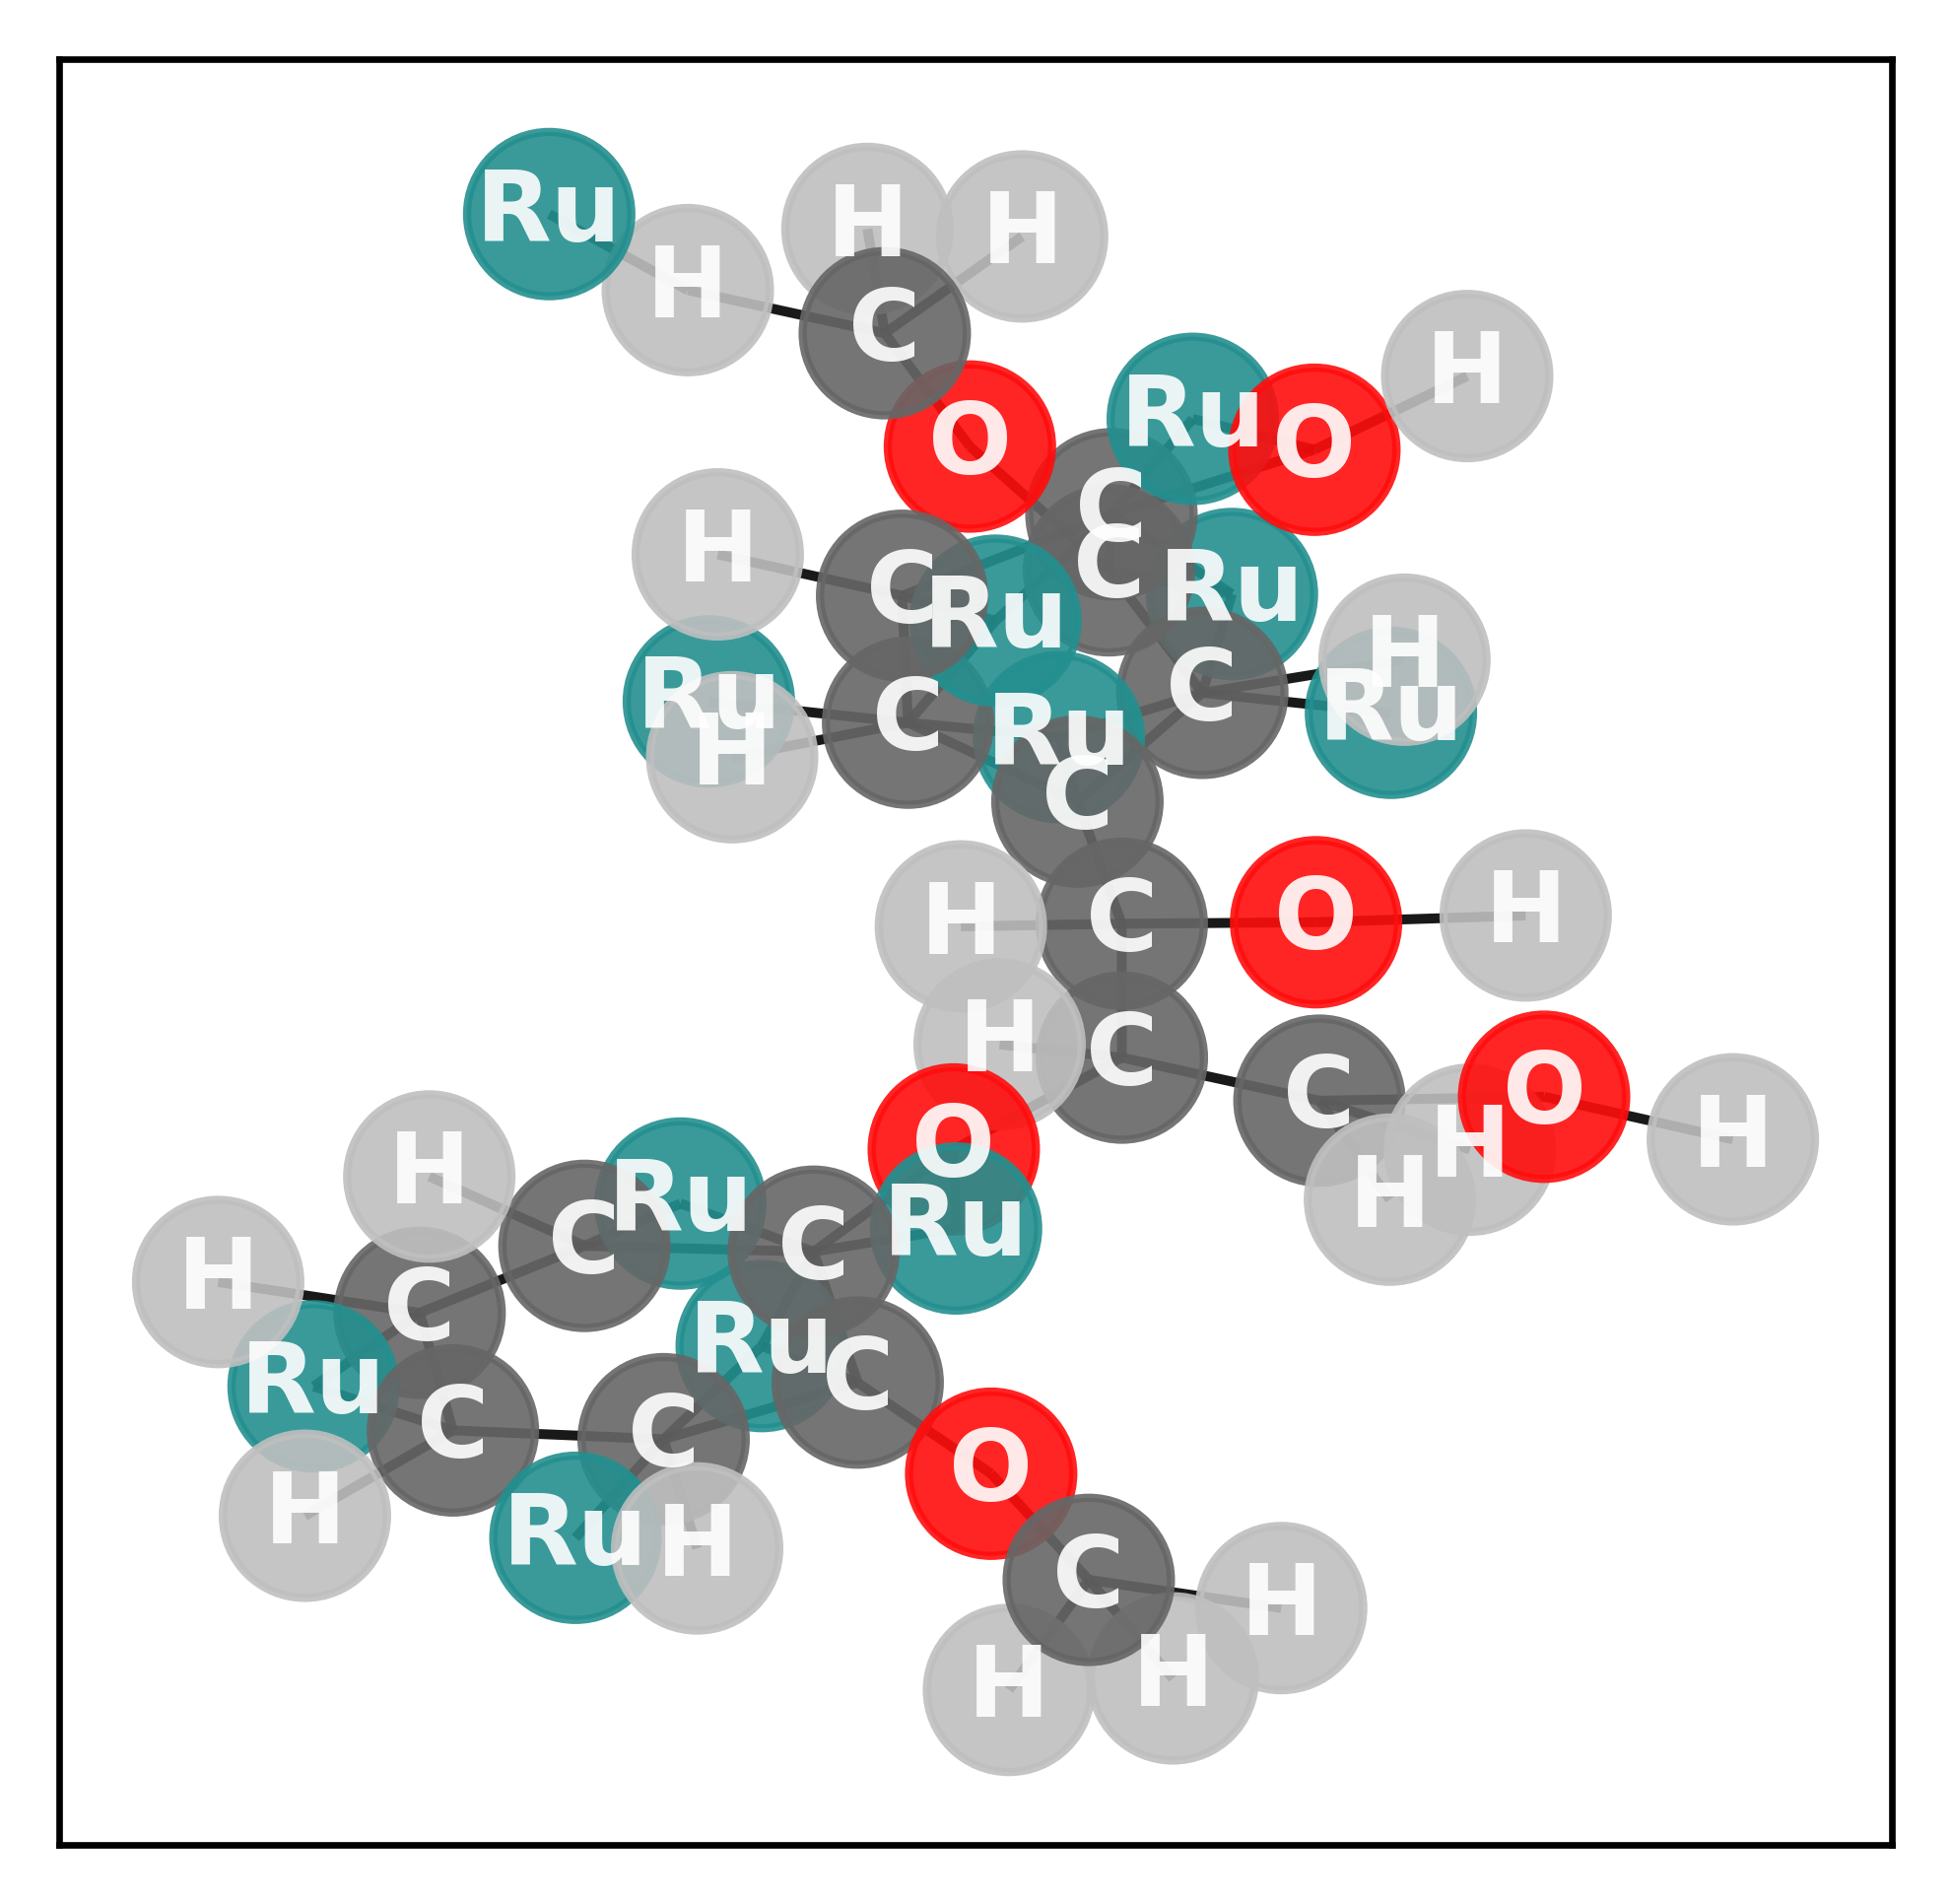

System: ru-mol2
GNN energy = -270.51 eV 
VASP energy = -269.7343701799999 eV
Prediction error = 0.77 eV
-----------------------------------


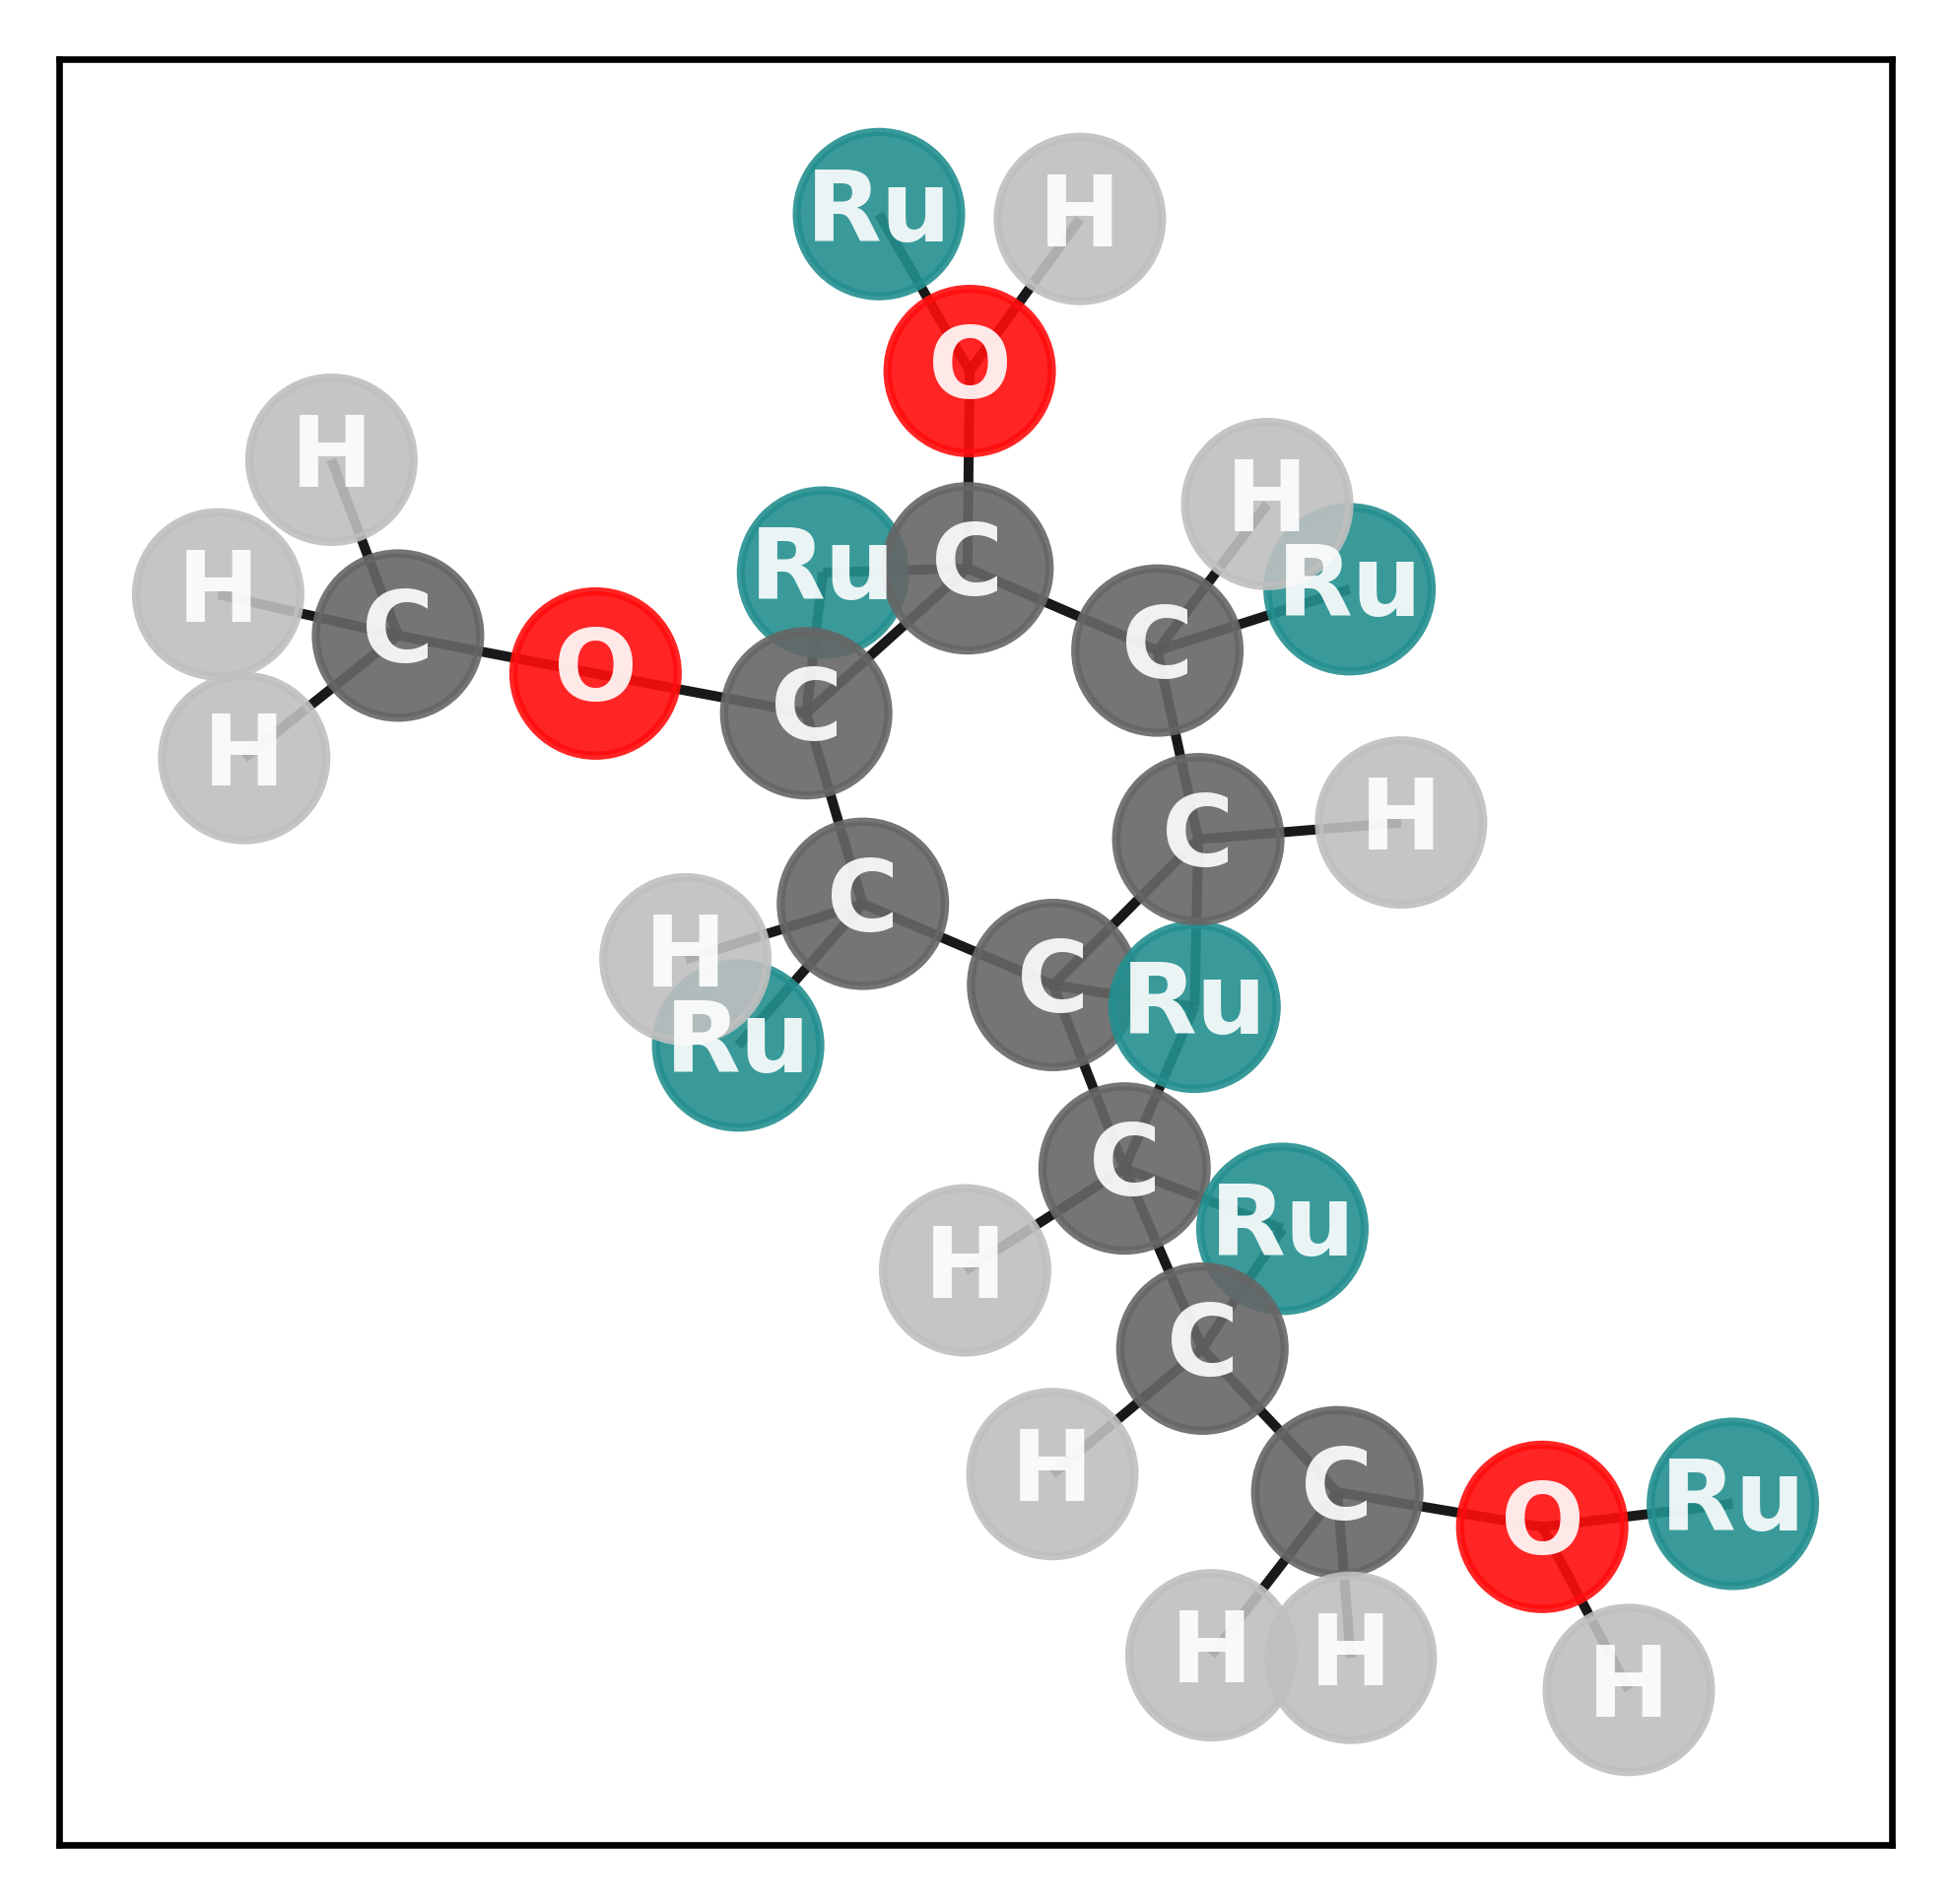

System: ru-mol3
GNN energy = -156.31 eV 
VASP energy = -157.01538868 eV
Prediction error = -0.70 eV
-----------------------------------


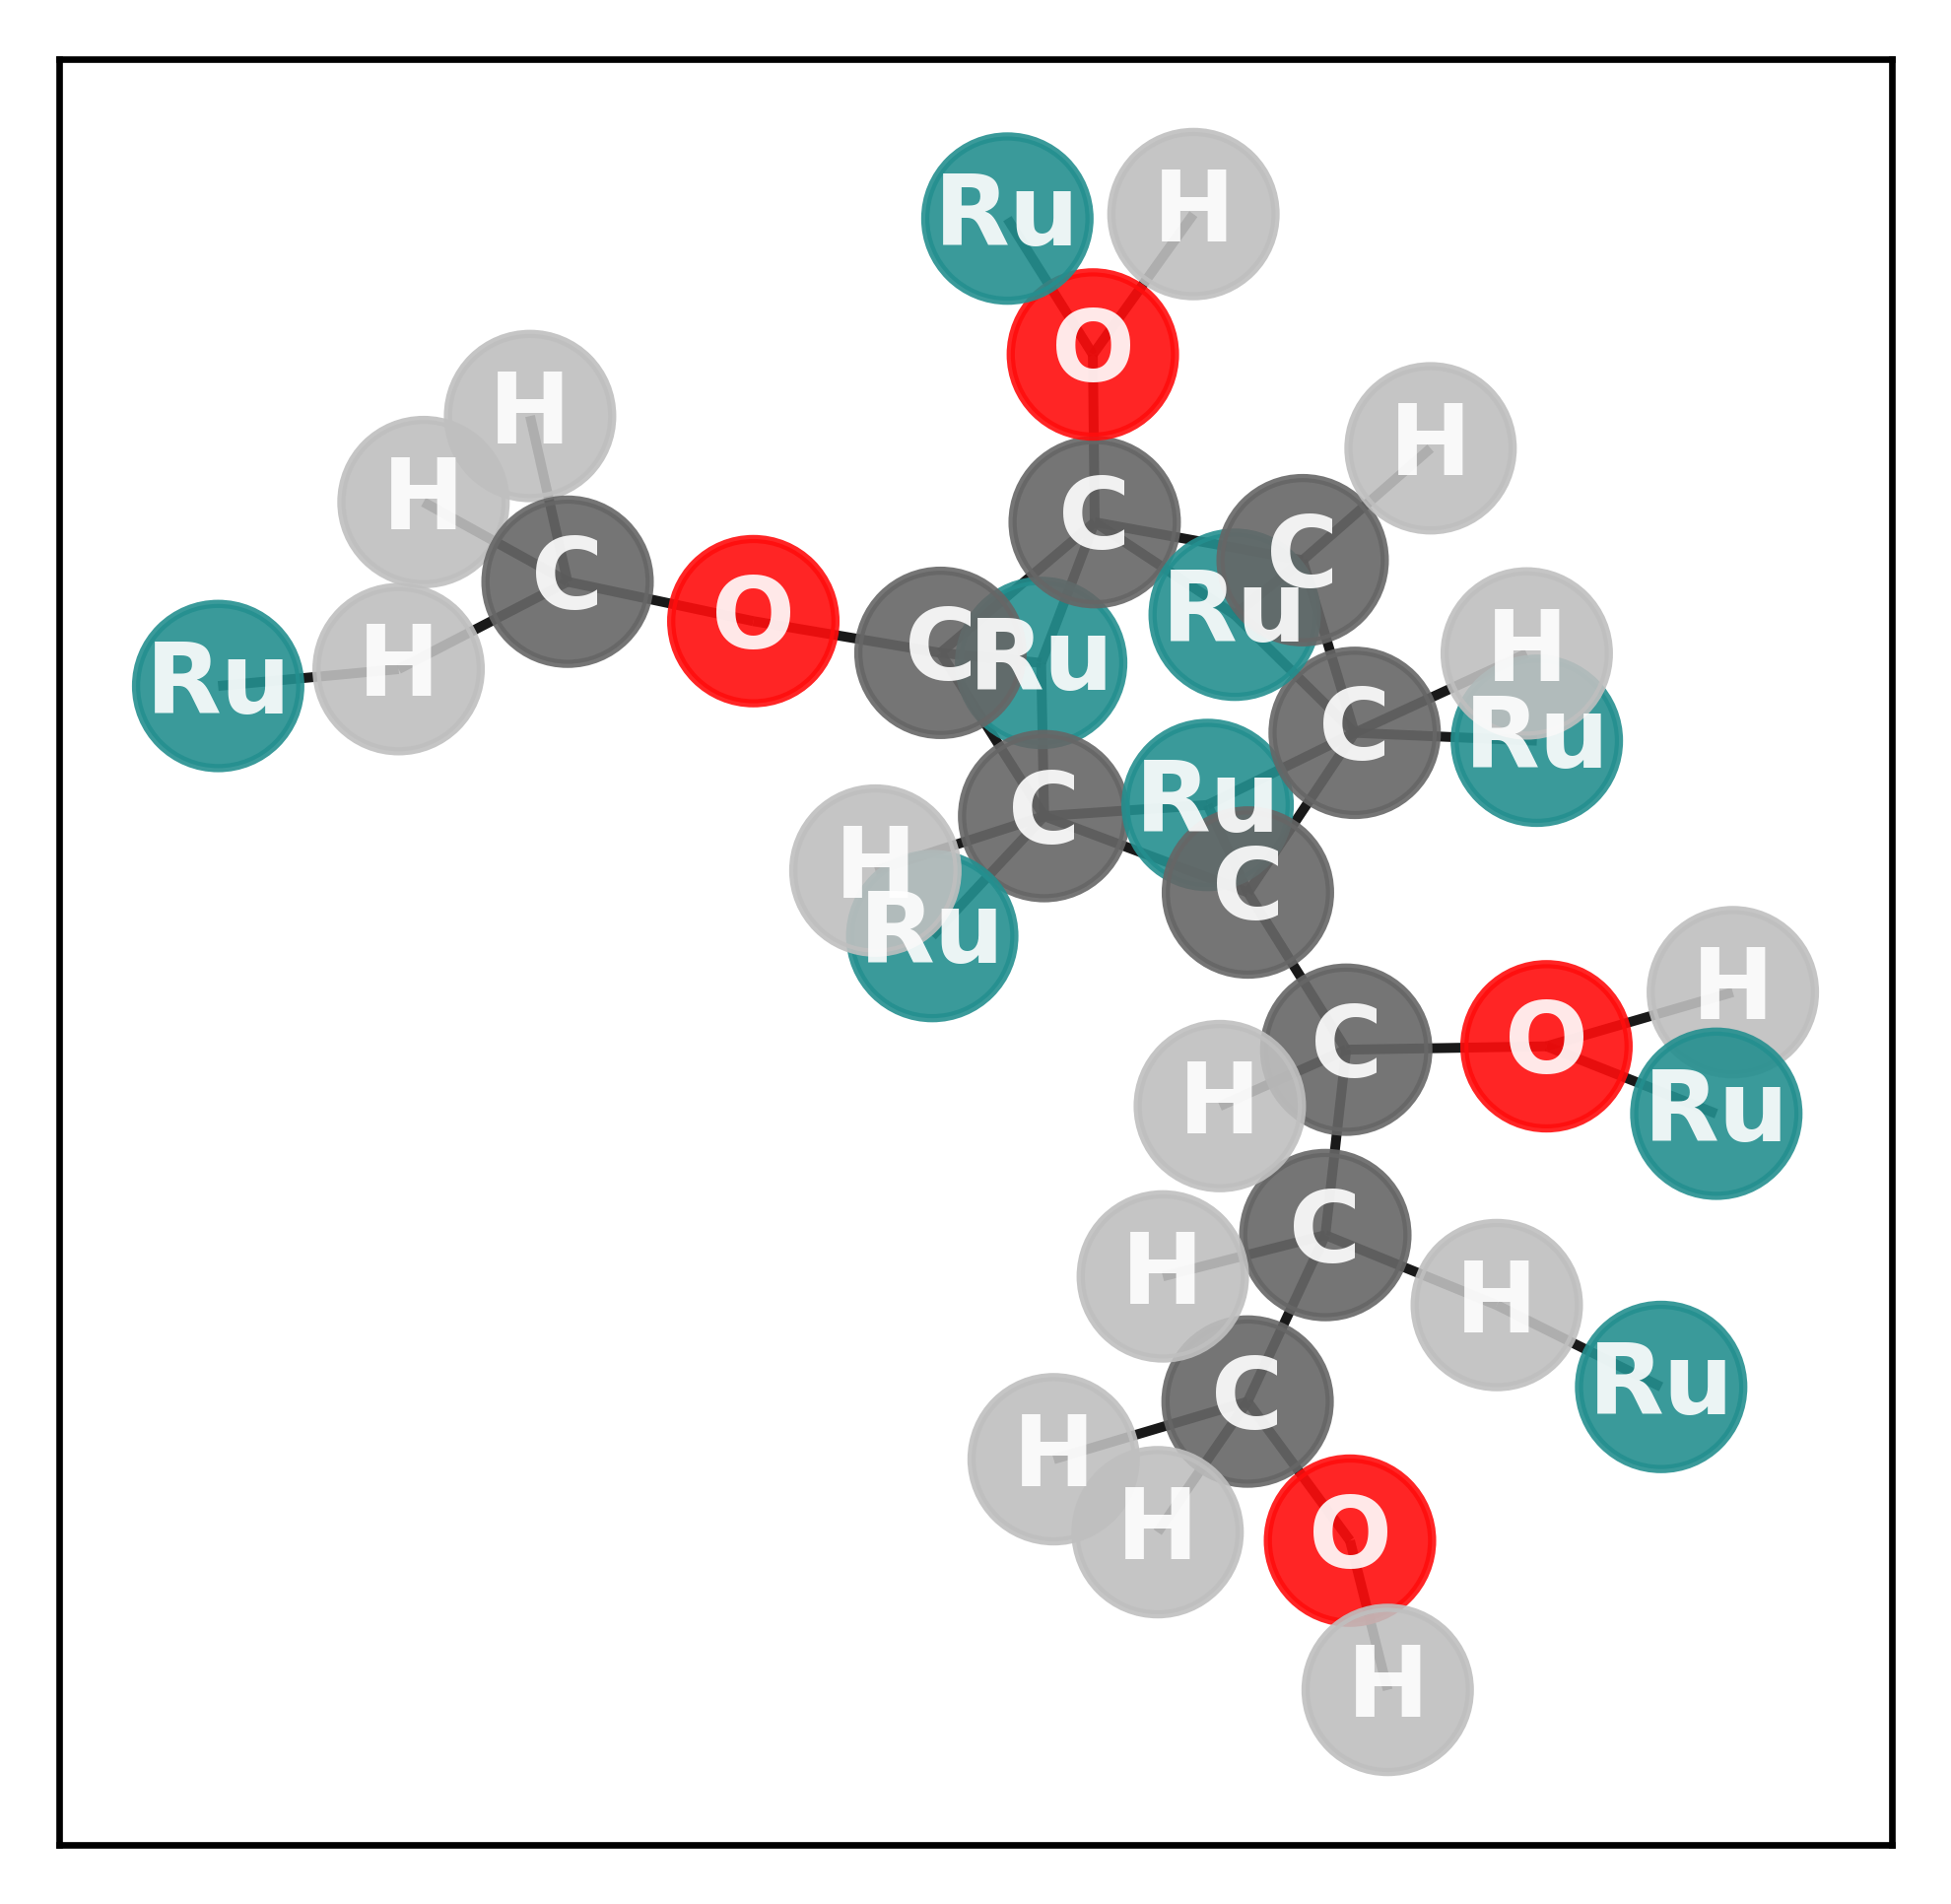

System: ru-mol4
GNN energy = -169.61 eV 
VASP energy = -171.17300477999993 eV
Prediction error = -1.57 eV
-----------------------------------


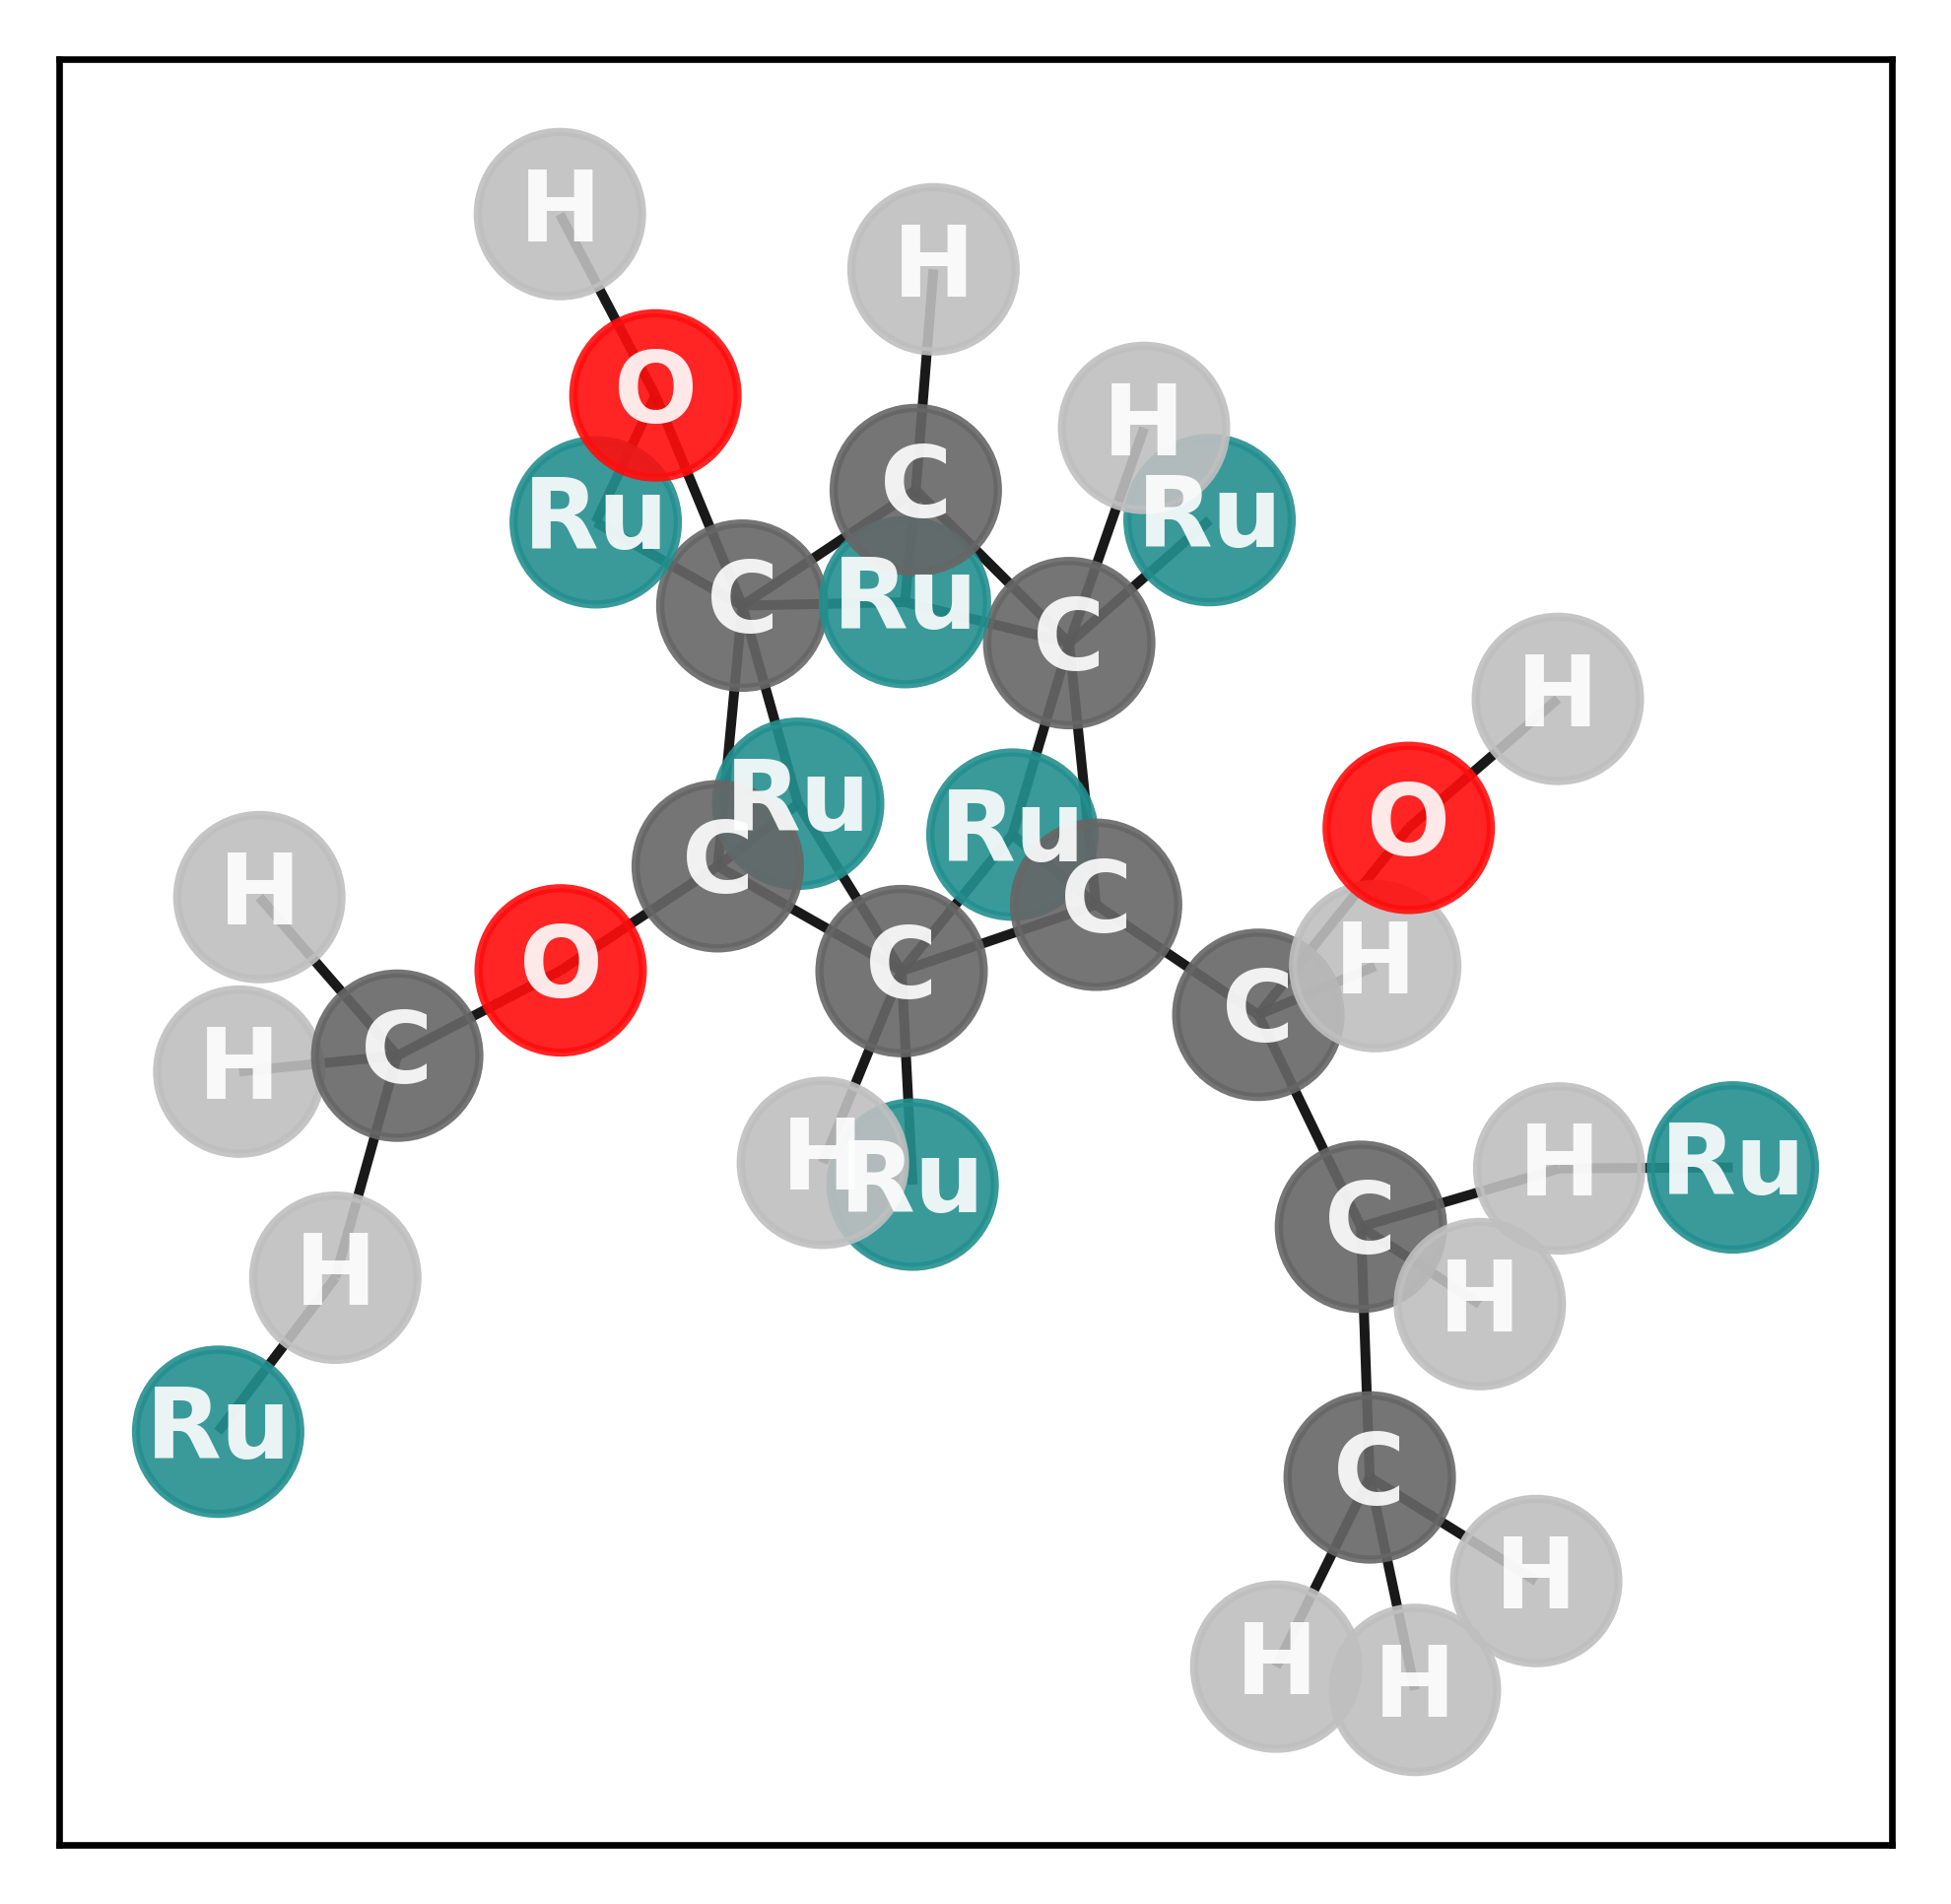

System: ru-mol5
GNN energy = -163.31 eV 
VASP energy = -164.19177753999998 eV
Prediction error = -0.88 eV
-----------------------------------


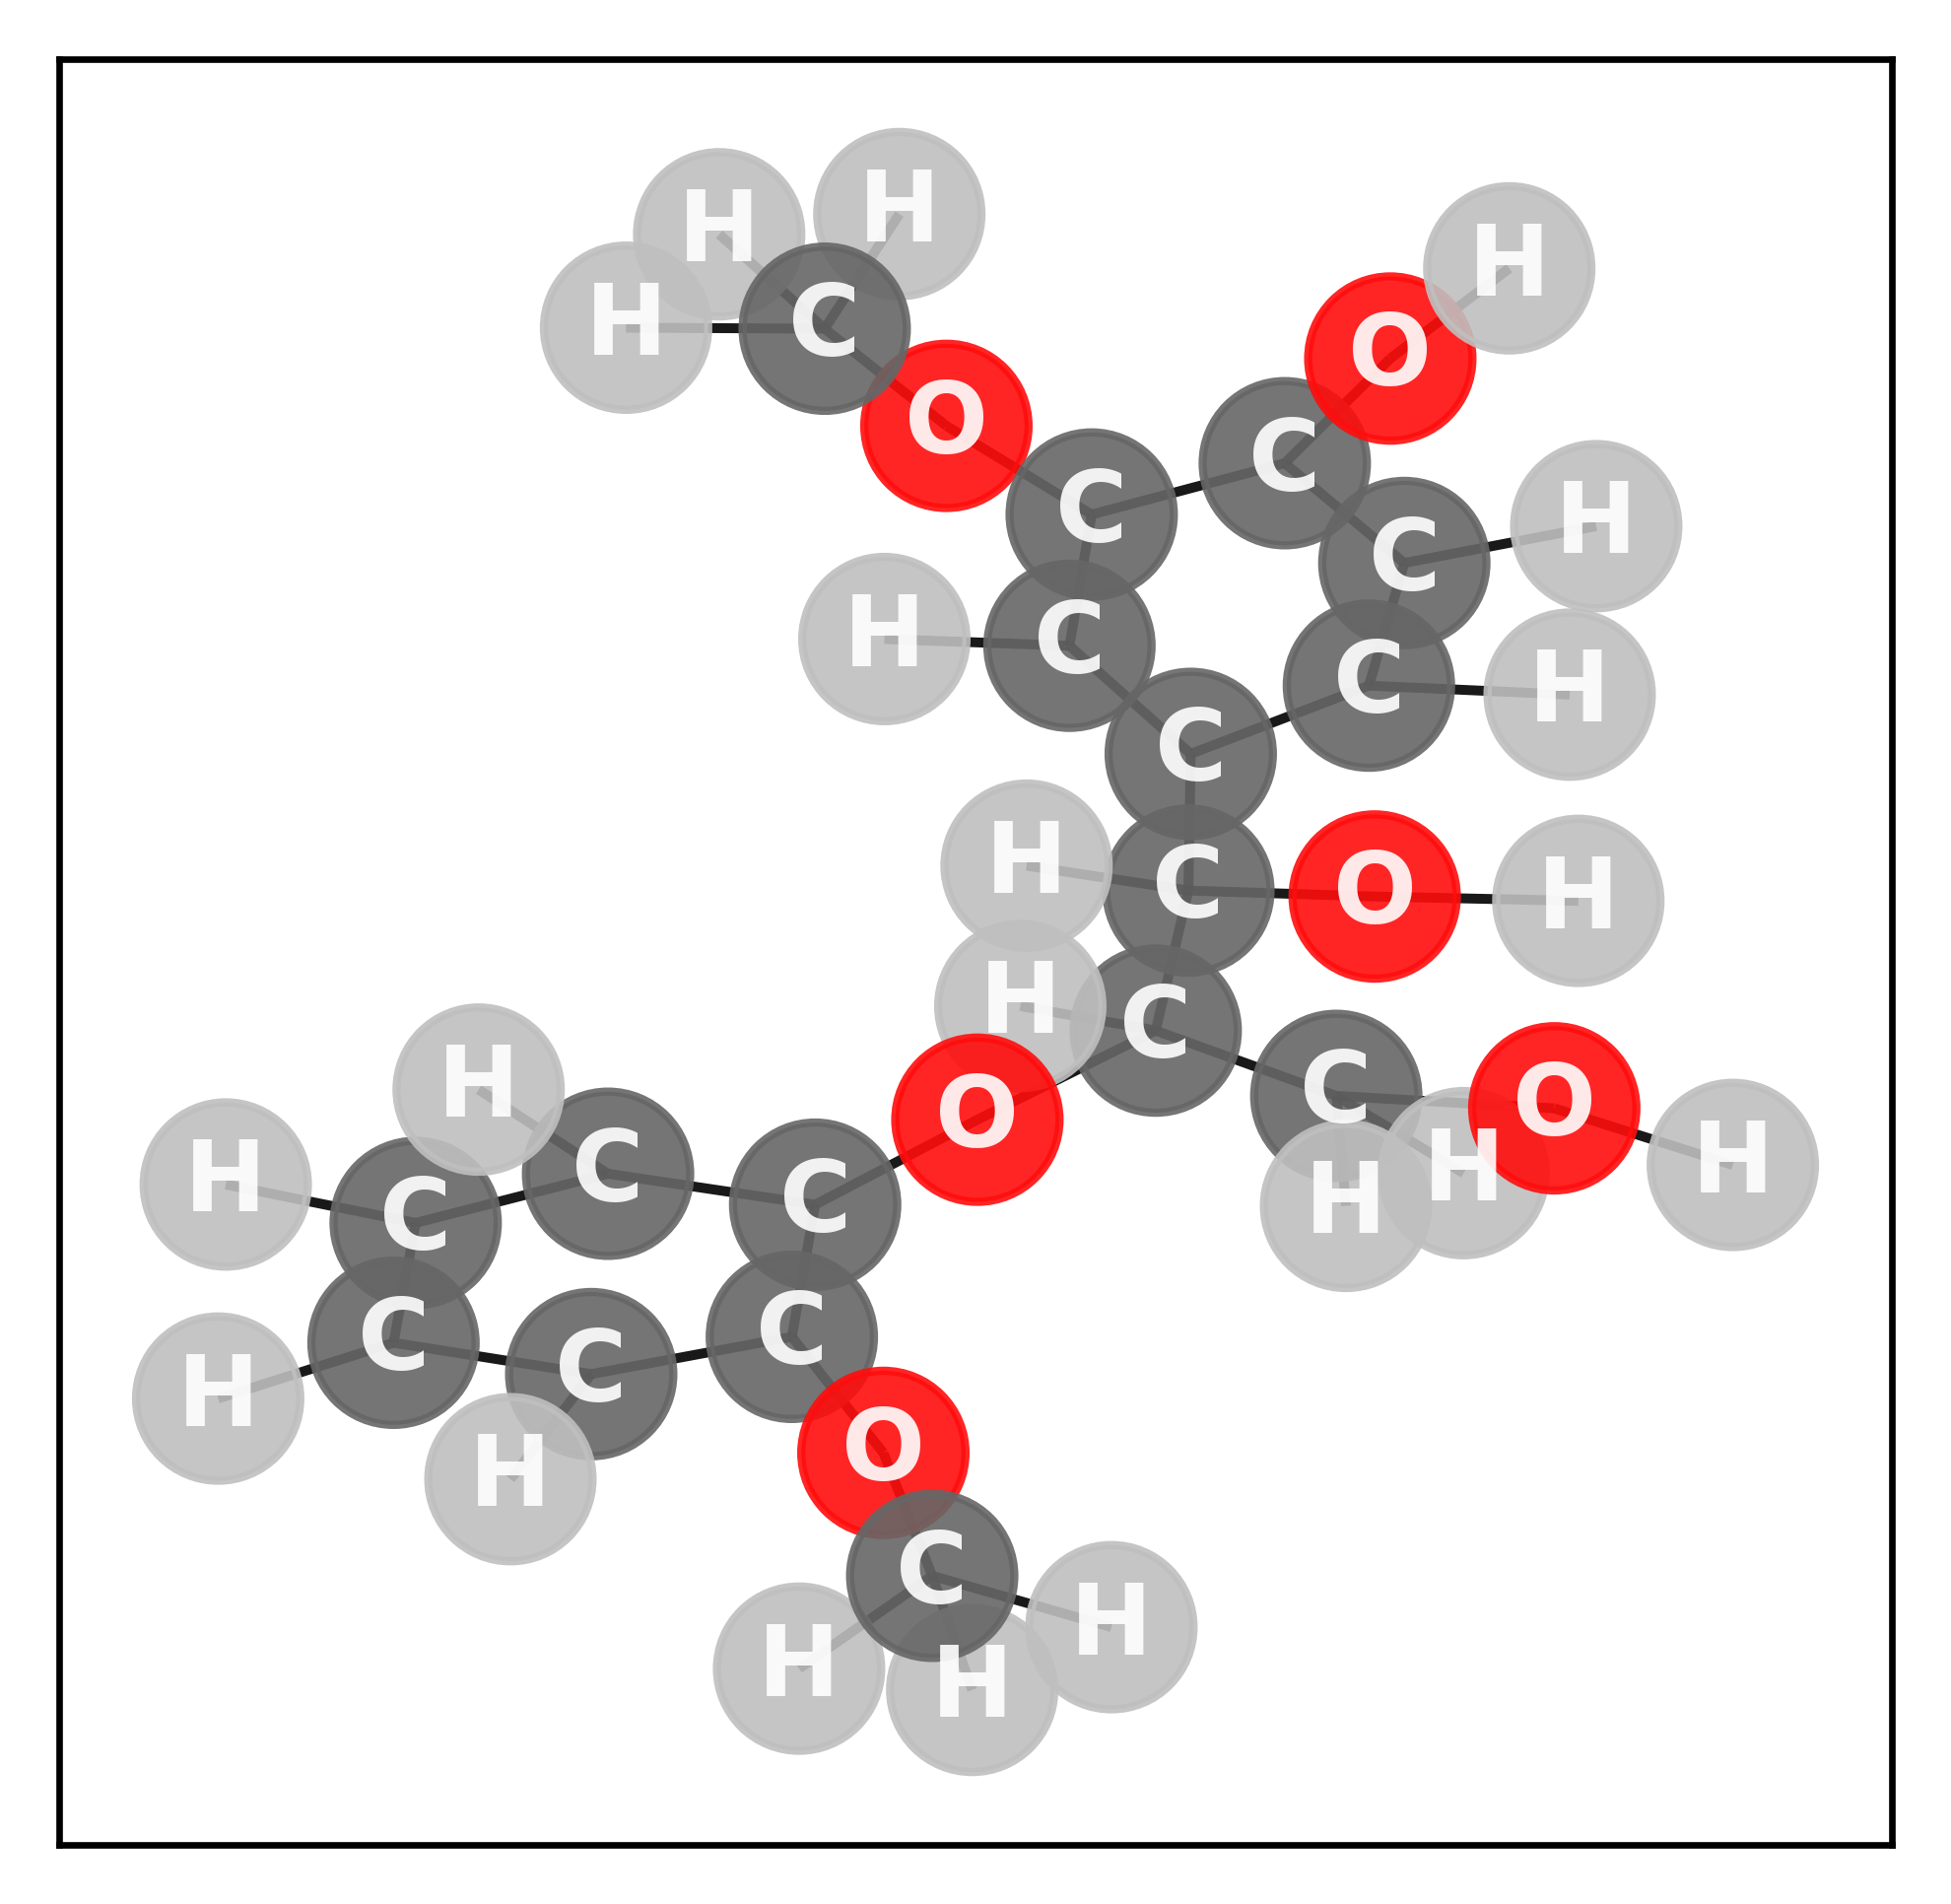

System: mol1
GNN energy = -265.72 eV 
VASP energy = -266.6203315 eV
Prediction error = -0.90 eV
-----------------------------------


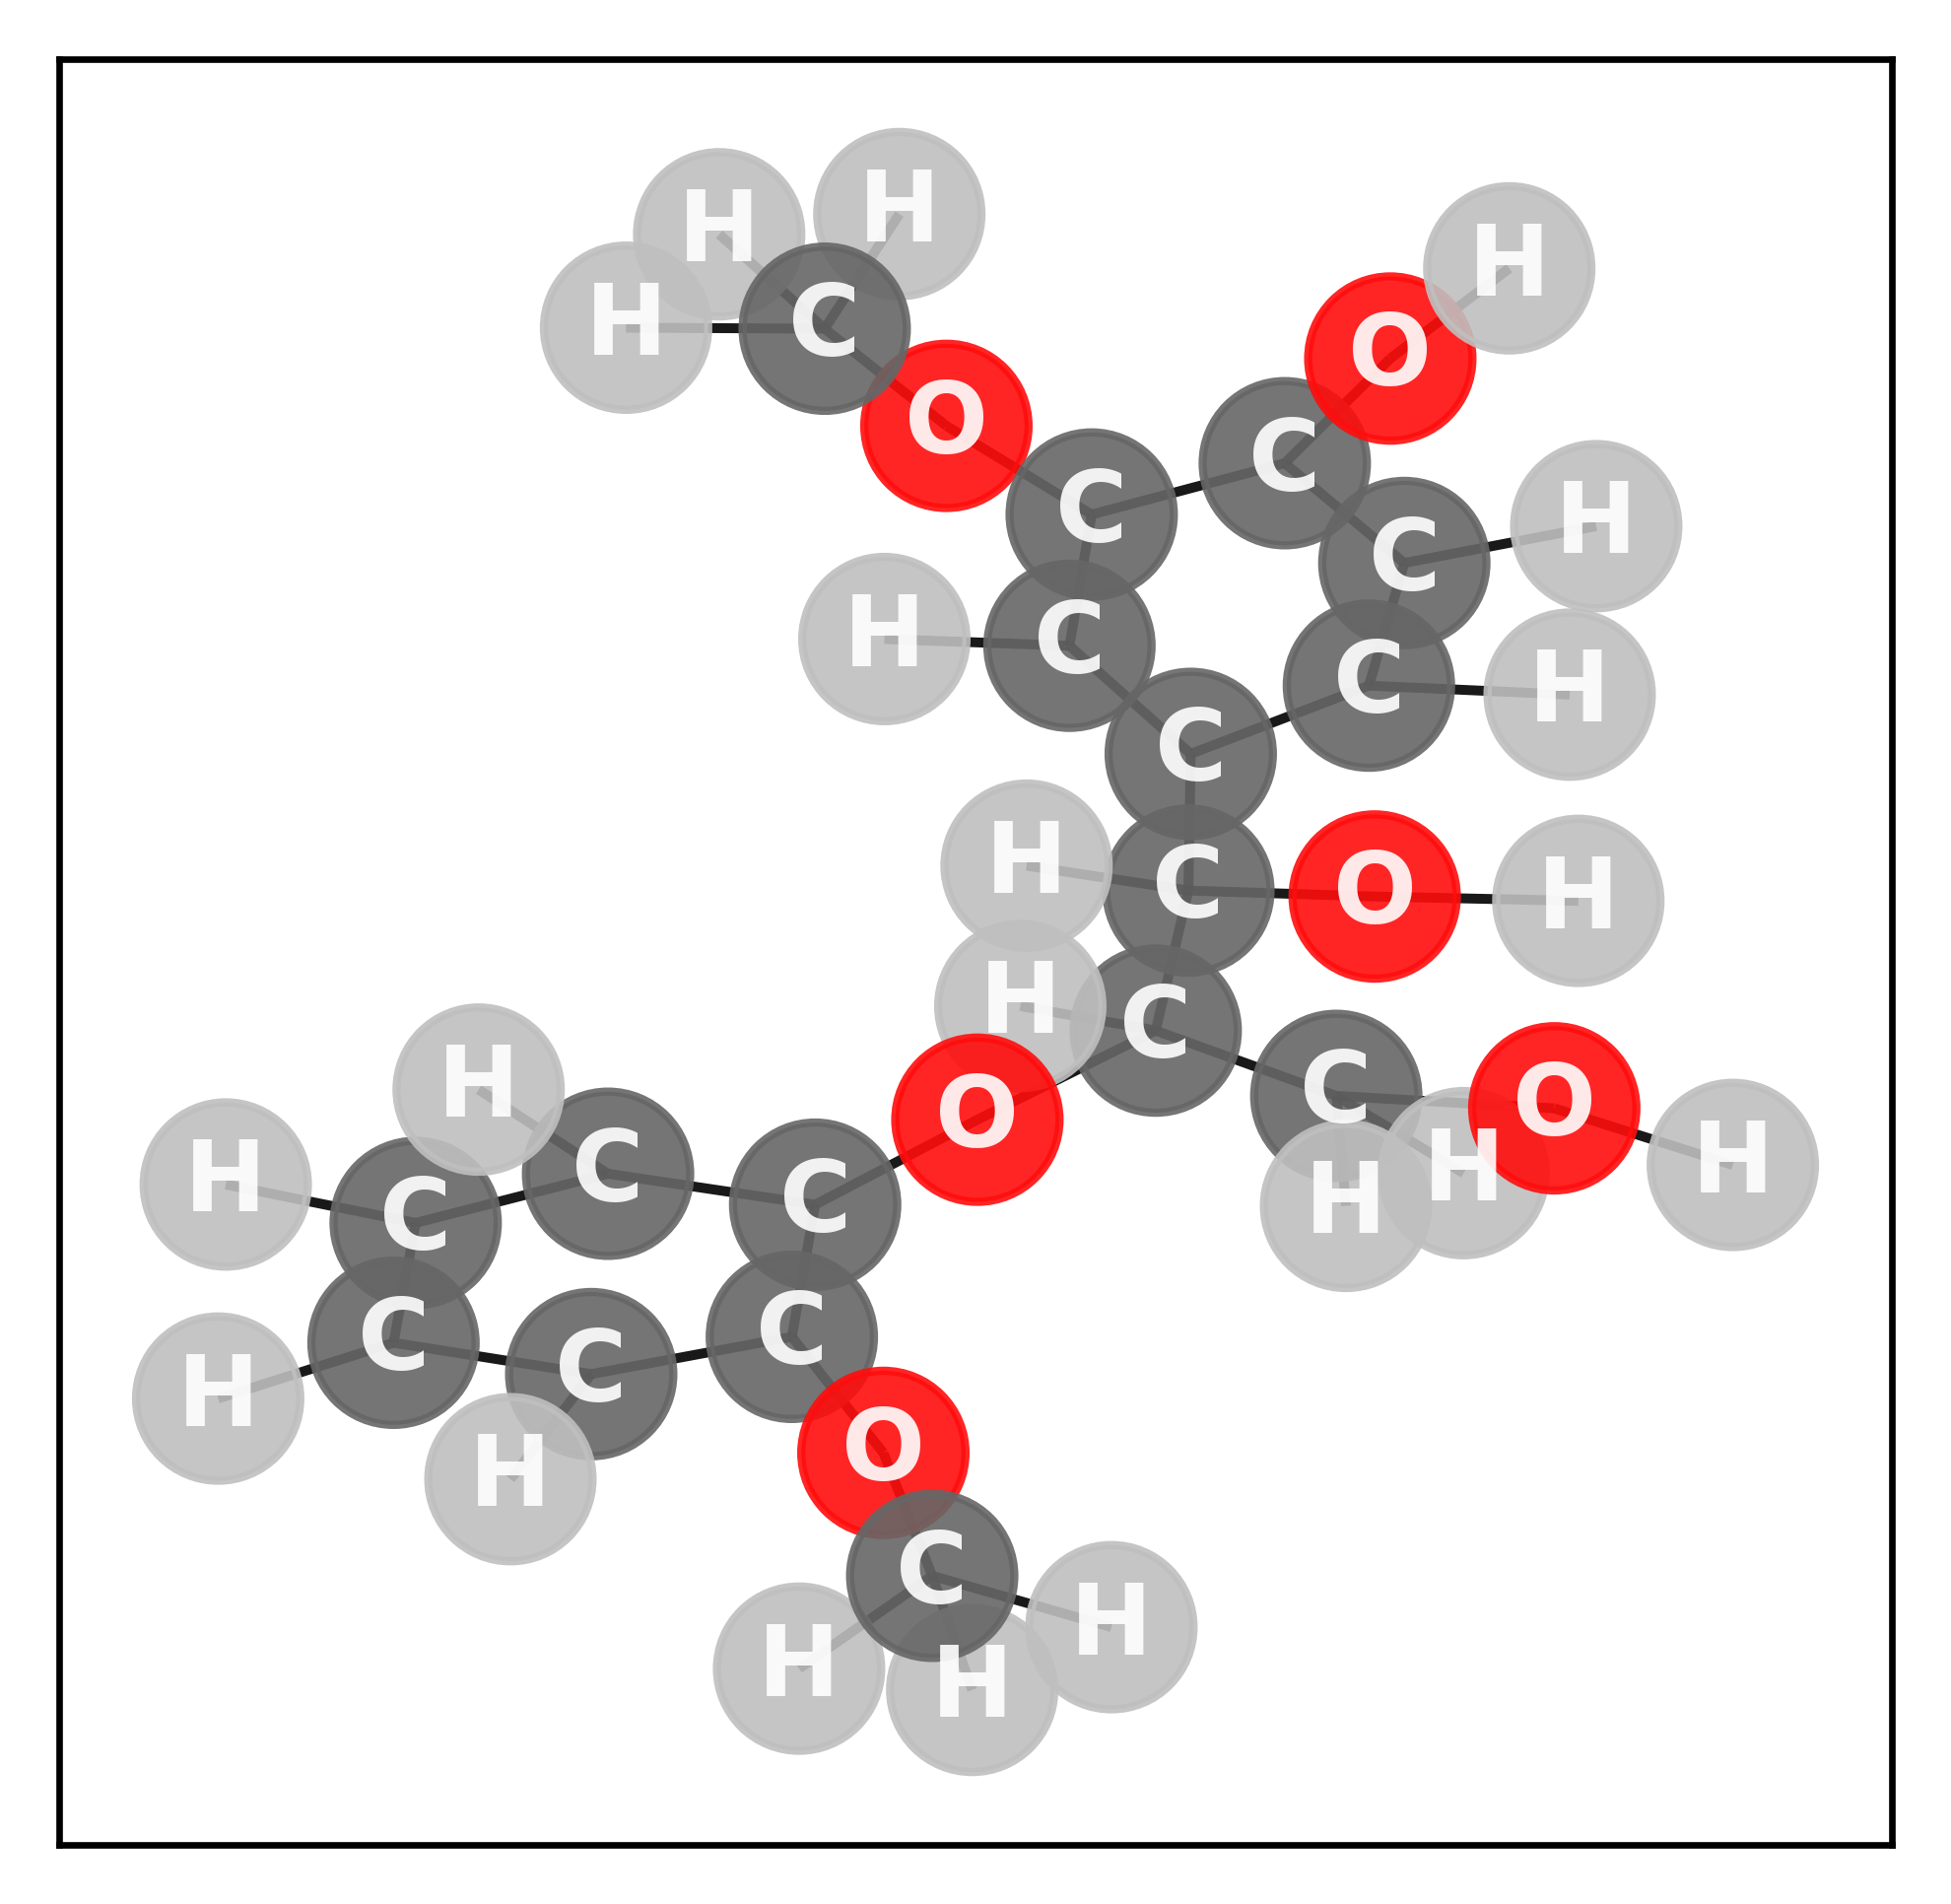

System: mol2
GNN energy = -265.72 eV 
VASP energy = -266.58212823 eV
Prediction error = -0.86 eV
-----------------------------------


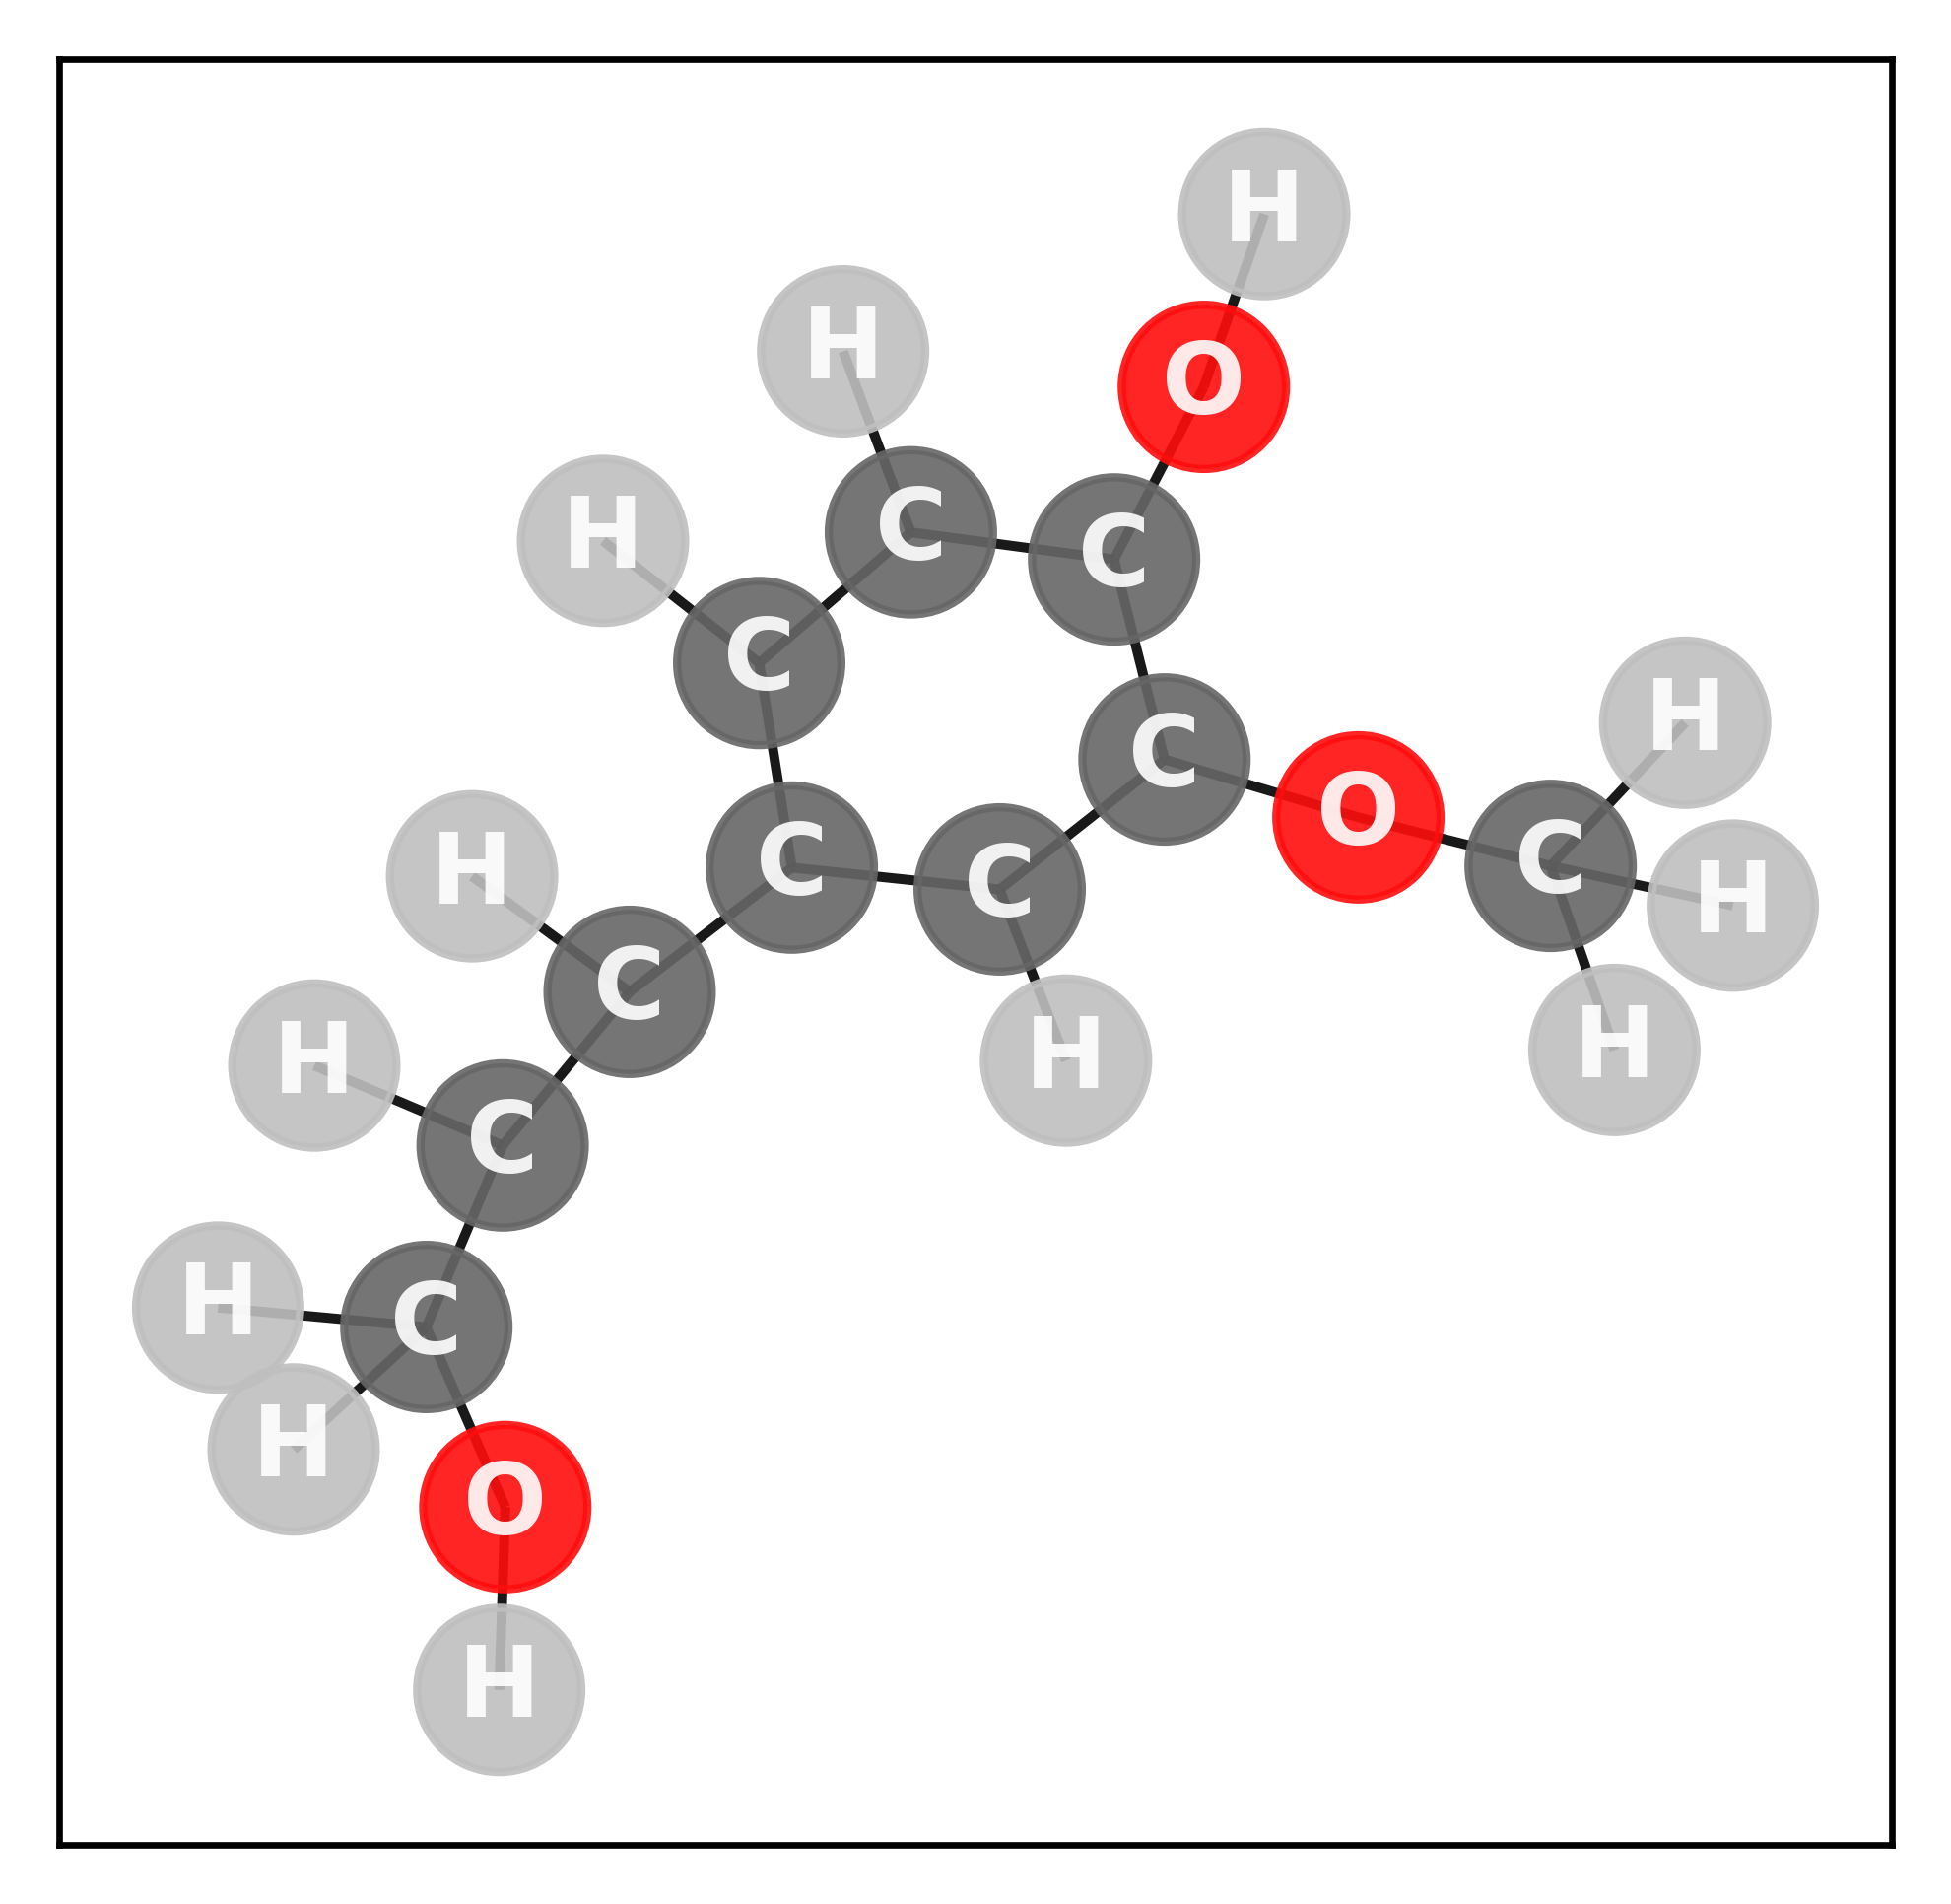

System: mol3
GNN energy = -153.86 eV 
VASP energy = -153.6018589 eV
Prediction error = 0.26 eV
-----------------------------------


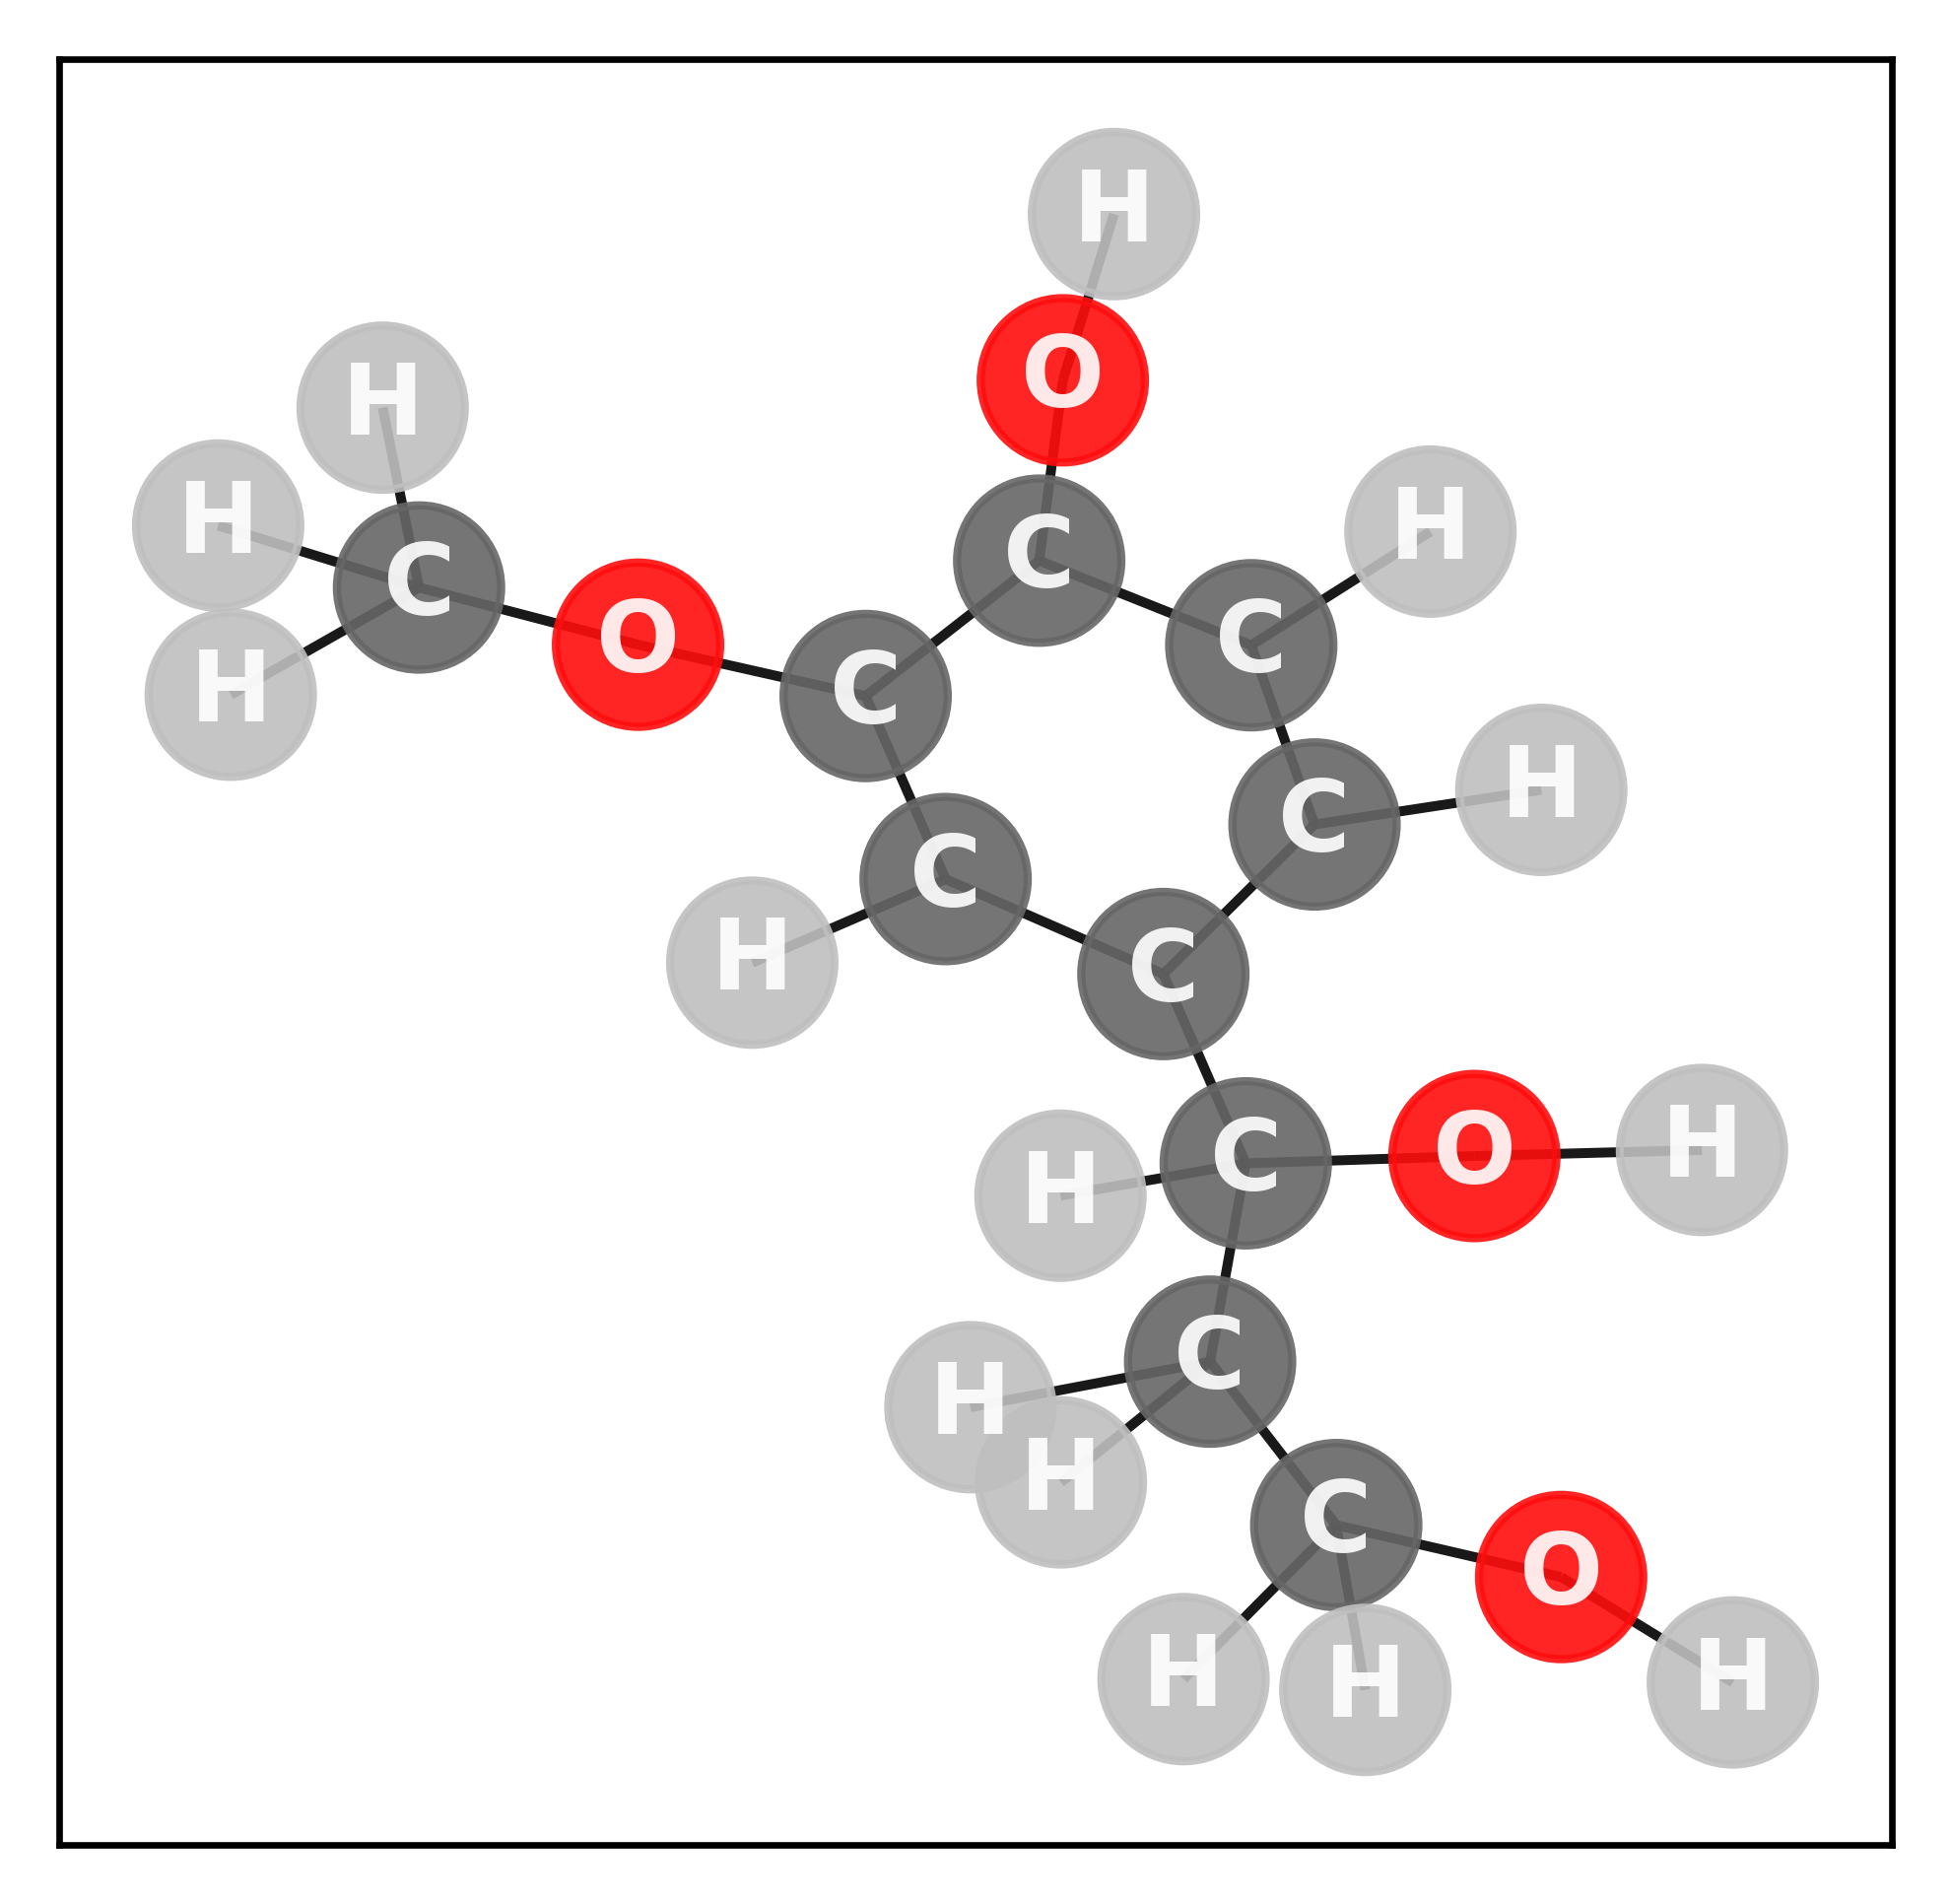

System: mol4
GNN energy = -168.42 eV 
VASP energy = -168.6743372 eV
Prediction error = -0.25 eV
-----------------------------------


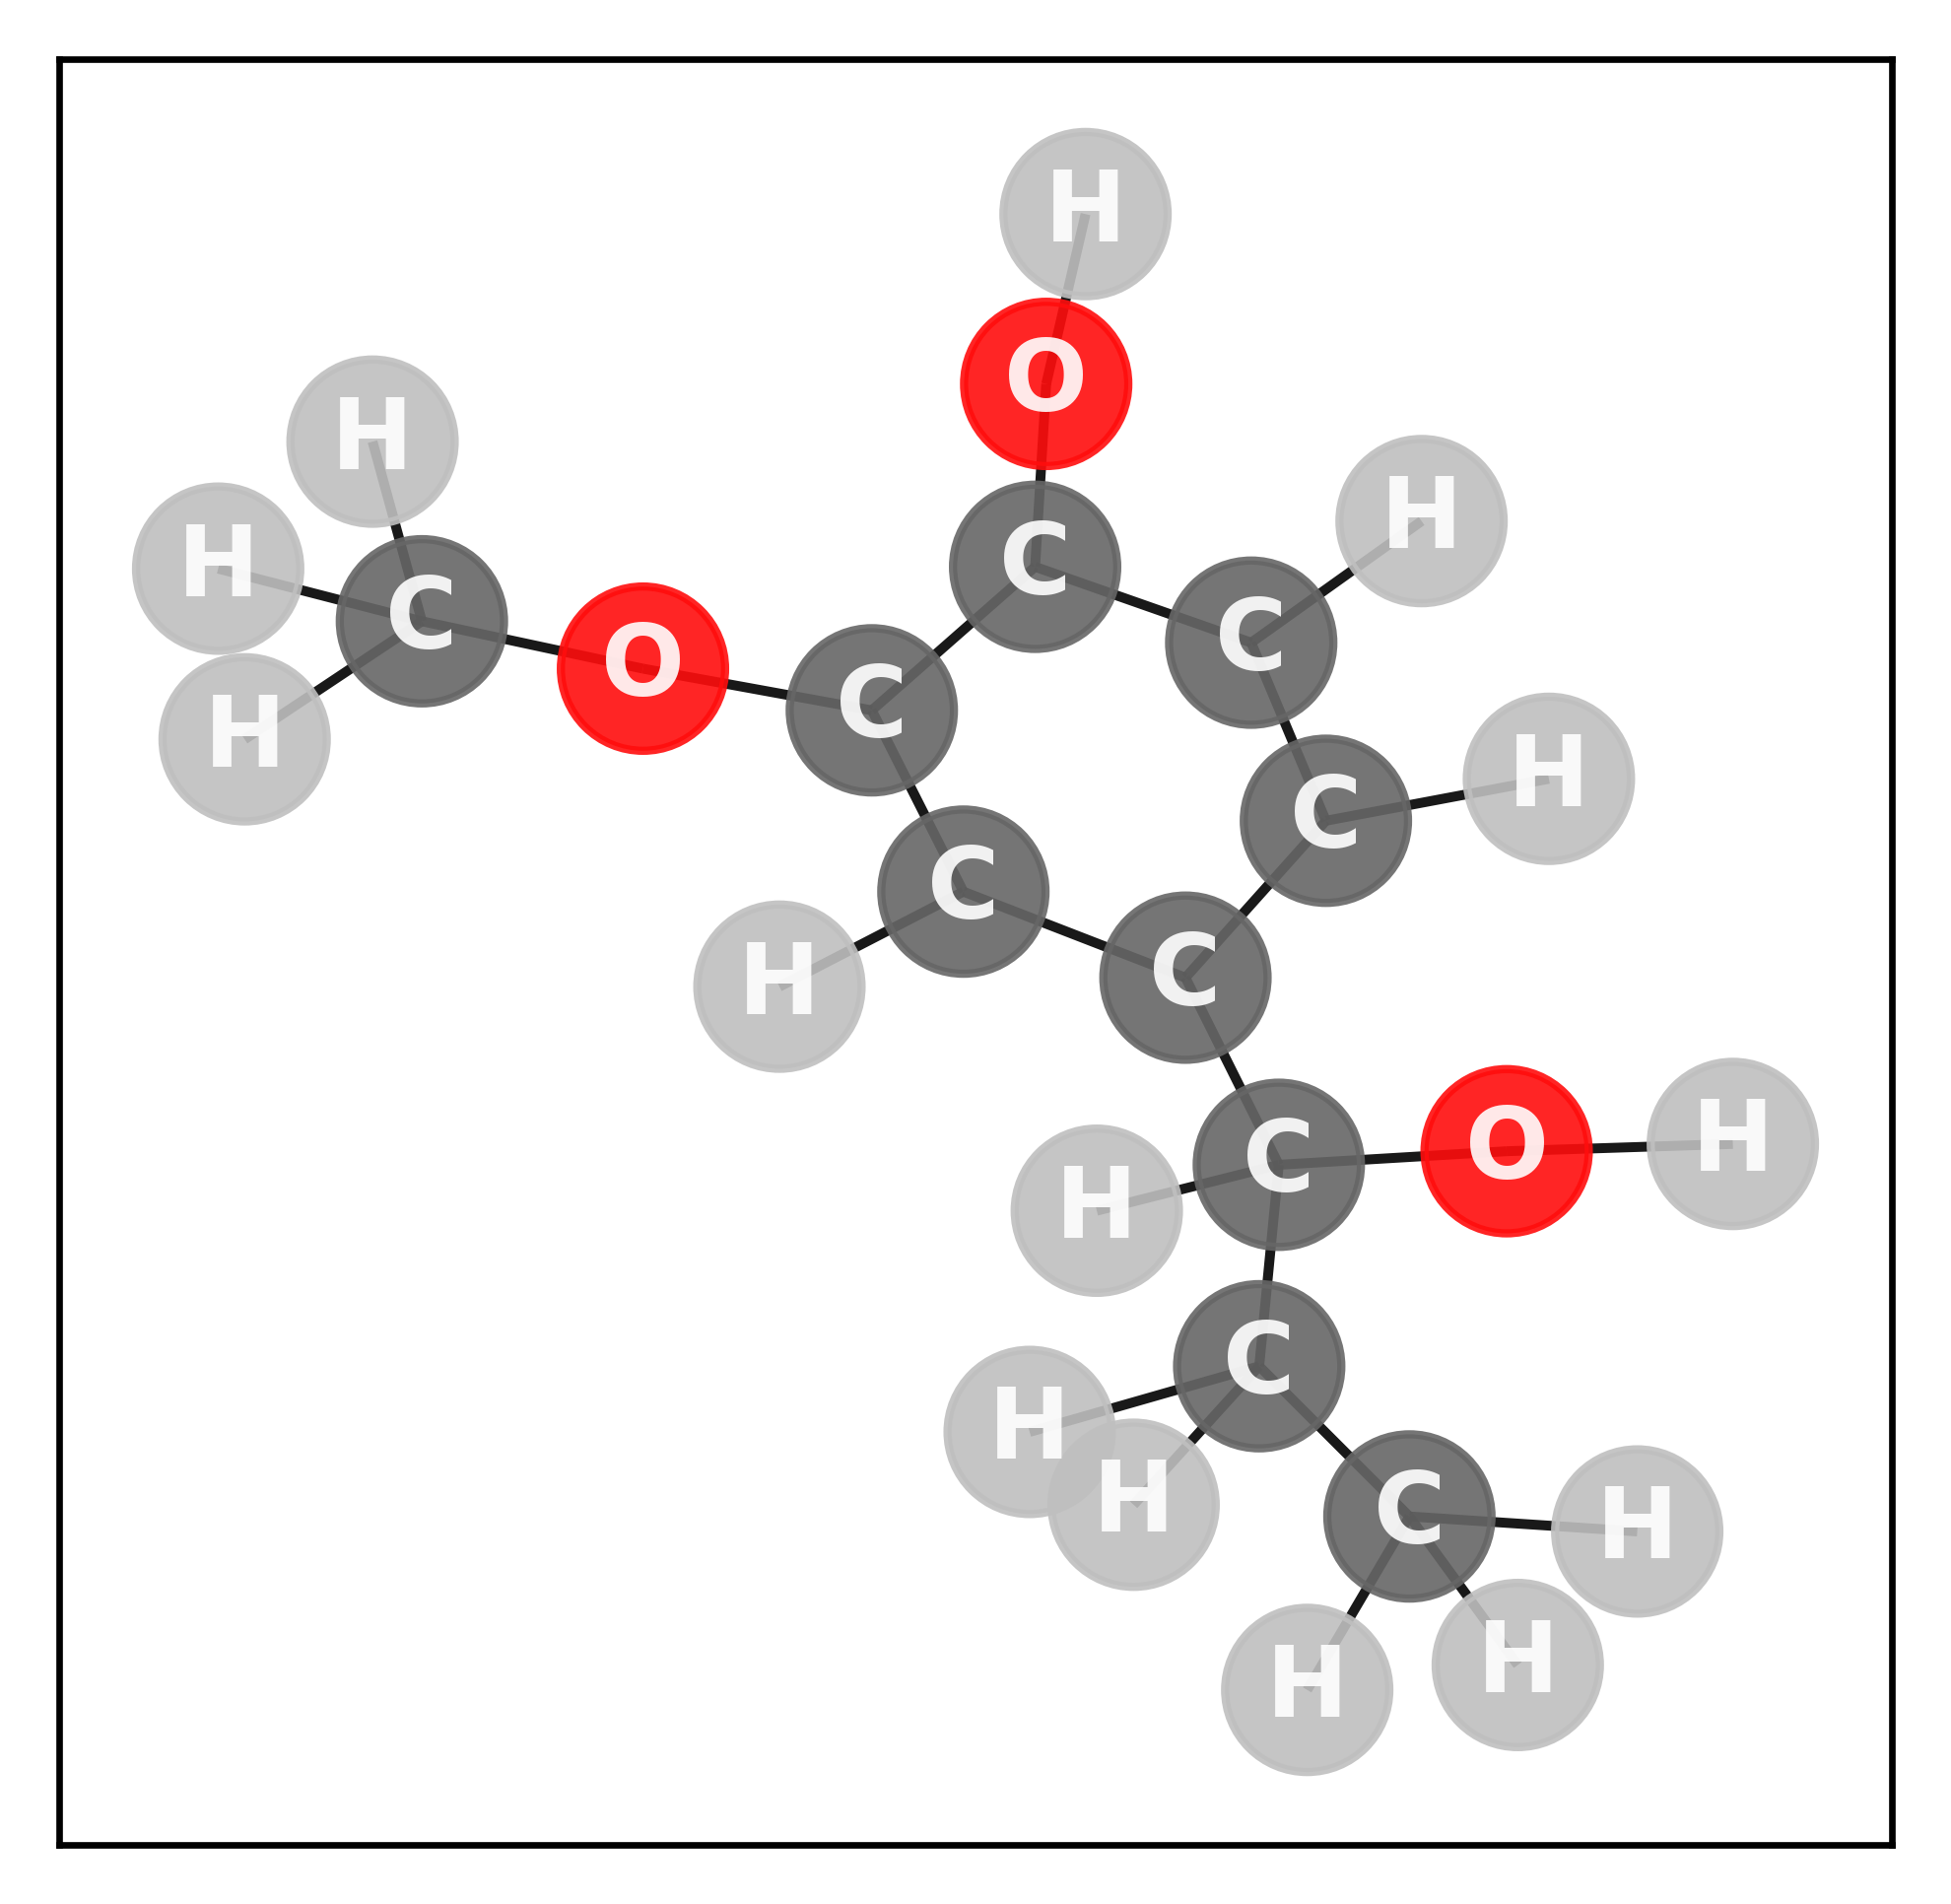

System: mol5
GNN energy = -162.22 eV 
VASP energy = -162.19930716 eV
Prediction error = 0.02 eV
----------BIOMASS-----------------
MAE = 0.62 eV
MAE/atom = 0.02 eV/atom
----------------------------------


In [1]:
from pymatgen.io.vasp import Outcar
from pyRDTP.geomio import file_to_mol
from functions import *
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
import torch
from graph_tools import plotter
import matplotlib.pyplot as plt
from classes import *
from nets import *

MODEL_NAME = "SN1"
MODEL_PATH = "./Models/{}/".format(MODEL_NAME)

ni_energy = Outcar("./Extrapolation/Biomass/ni-0000/OUTCAR").final_energy
ru_energy = Outcar("./Extrapolation/Biomass/ru-0000/OUTCAR").final_energy
sur = ["ni", "ru"]
pu = ["mol1", "mol2", "mol3", "mol4", "mol5"]
sur_energy = {"ni": ni_energy, "ru": ru_energy}
file = open("{}performance.txt".format(MODEL_PATH))
lines = file.readlines()
mean_tv = float(lines[3].split()[-2])
std_tv = float(lines[4].split()[-2])
model = SantyxNet(dim=128, node_features=node_features)
model.load_state_dict(torch.load("{}GNN.pth".format(MODEL_PATH)))
model.eval()
error = np.zeros((len(pu)*(1 + len(sur)),1))
error_per_atom = np.zeros((len(pu)*(1 + len(sur)),1))
abs_error = np.zeros((len(pu)*(1 + len(sur)),1))
counter = 0
for metal in sur:
    for molecule in pu:
        calc = "{}-{}".format(metal, molecule)
        system = "./Extrapolation/Biomass/{}/CONTCAR".format(calc)
        s = Outcar("./Extrapolation/Biomass/{}/OUTCAR".format(calc))
        s = s.final_energy
        mol = file_to_mol(system, 'contcar', bulk=False)
        mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
        nx_graph = ensemble_to_graph(mol)
        elem = list(nx_graph[1][0])
        source = list(nx_graph[1][1][0])
        target = list(nx_graph[1][1][1])
        elem_array = np.array(elem).reshape(-1, 1)
        elem_enc = encoder.transform(elem_array).toarray()
        edge_index = torch.tensor([source, target], dtype=torch.long)
        x = torch.tensor(elem_enc, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        DL = DataLoader([data], batch_size=1, shuffle=False)   
        for batch in DL:
            energy = model(batch).item() * std_tv + mean_tv
        print("-----------------------------------")
        plotter(data)
        plt.show()
        print("System: {}-{}".format(metal, molecule))
        print("GNN energy = {:.2f} eV ".format(energy))
        print("VASP energy = {} eV".format(s - sur_energy[metal]))
        print("Prediction error = {:.2f} eV".format(s - sur_energy[metal] - energy))
        error[counter] = s - sur_energy[metal] - energy
        abs_error[counter] = abs(error[counter])
        error_per_atom[counter] = abs_error[counter] / data.num_nodes
        counter += 1
for molecule in pu:  # gas phase molecules
    calc = "{}".format(molecule)
    system = "./Extrapolation/Biomass/{}/CONTCAR".format(calc)
    s = Outcar("./Extrapolation/Biomass/{}/OUTCAR".format(calc))
    s = s.final_energy
    mol = file_to_mol(system, 'contcar', bulk=False)
    mol = mol_to_ensemble(mol, VORONOI_TOLERANCE, CORDERO)
    nx_graph = ensemble_to_graph(mol)
    elem = list(nx_graph[1][0])
    source = list(nx_graph[1][1][0])
    target = list(nx_graph[1][1][1])
    elem_array = np.array(elem).reshape(-1, 1)
    elem_enc = encoder.transform(elem_array).toarray()
    edge_index = torch.tensor([source, target], dtype=torch.long)
    x = torch.tensor(elem_enc, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    DL = DataLoader([data], batch_size=1, shuffle=False)   
    for batch in DL:
        energy = model(batch).item() * std_tv + mean_tv
    print("-----------------------------------")
    plotter(data)
    plt.show()
    print("System: {}".format(molecule))
    print("GNN energy = {:.2f} eV ".format(energy))
    print("VASP energy = {} eV".format(s))
    print("Prediction error = {:.2f} eV".format(s- energy))
    error[counter] = s - energy
    abs_error[counter] = abs(error[counter])
    error_per_atom[counter] = abs_error[counter] / data.num_nodes
    counter += 1
print("----------BIOMASS-----------------")
print("MAE = {:.2f} eV".format(np.mean(abs_error)))
print("MAE/atom = {:.2f} eV/atom".format(np.mean(error_per_atom)))
print("----------------------------------")
        